# Initialization

## Install Libraries

In [1]:
!pip install pandas
!pip install seaborn
!pip install tqdm
!pip install plotly
!pip install statsmodels
!pip install -U scikit-learn
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import datetime as DT
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import random
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import xgboost as XGBoost
import math
# import tensorflow as tf

# Project Overview

**Horse Racing Analysis**

*Purpose:*
The goal is to predict horse finish times (regression) and to predict which horse will win the race (classification).

*Methodology:*
- Regression:
    - data wrangling
        - merge race data with runs data
        - address null values
        - convert string data into numeric formats
    - feature selection / engineering
        - utilize feature rolling averages (e.g. moving average of finishing times)
    - baseline
        - average finishing time by race distance
    - model selection
        - linear regression
        - random forest regressor
        - gradient boosting regressor
        - multilayer perceptron regressor
        - k nearest neighbors
    - hyperparameter tuning
    - ensemble (of best performing models)
    - feature importance analysis
        - aggregate normalized importance metrics
            - beta values for logistic regression and Gini importance for decision trees
            - scale results between 0 and 1
- Classification:
    - data wrangling
        - combine individual rows of horse info into a single race instance containing features of each horse
        - address null values
            - specifically unoccupied race positions (classes) occuring when fewer horses are competing in a race
        - address class imbalance
            - randomly permute the horse positions to evenly distribute occupied horse positions and winner positions
        - convert string data into numeric formats
    - baseline
        - pick horse with best winning odds (one of the included features)
    - feature selection / engineering
        - utilize feature rolling averages (e.g. moving average of finishing times)
    - model selection
        - logistic regression
        - random forest classifier
        - gradient boosting classifier
        - multilayer perceptron classifier
    - hyperparameter tuning
    - ensemble (of best performing models)
    - feature importance analysis
        - aggregate normalized importance metrics
            - beta values for logistic regression and Gini importance for decision trees
            - scale results between 0 and 1

# Wrangling / EDA

## Import Data

In [3]:
races_df = pd.read_csv('races.csv')
runs_df = pd.read_csv('runs.csv')

Remove any duplicates.

In [4]:
races_df = races_df.drop_duplicates()
runs_df = runs_df.drop_duplicates()

Inspect races data.

In [5]:
races_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6349 entries, 0 to 6348
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   race_id             6349 non-null   int64  
 1   date                6349 non-null   object 
 2   venue               6349 non-null   object 
 3   race_no             6349 non-null   int64  
 4   config              6349 non-null   object 
 5   surface             6349 non-null   int64  
 6   distance            6349 non-null   int64  
 7   going               6349 non-null   object 
 8   horse_ratings       6349 non-null   object 
 9   prize               5887 non-null   float64
 10  race_class          6349 non-null   int64  
 11  sec_time1           6349 non-null   float64
 12  sec_time2           6349 non-null   float64
 13  sec_time3           6349 non-null   float64
 14  sec_time4           3634 non-null   float64
 15  sec_time5           821 non-null    float64
 16  sec_ti

In [6]:
races_df.head()

,race_id,date,venue,race_no,config,surface,distance,going,horse_ratings,prize,...,place_combination3,place_combination4,place_dividend1,place_dividend2,place_dividend3,place_dividend4,win_combination1,win_dividend1,win_combination2,win_dividend2
0,0,1997-06-02,ST,1,A,0,1400,GOOD TO FIRM,40-15,485000.0,...,6.0,NaN,36.5,25.5,18.0,NaN,8,121.0,NaN,NaN
1,1,1997-06-02,ST,2,A,0,1200,GOOD TO FIRM,40-15,485000.0,...,4.0,NaN,12.5,47.0,33.5,NaN,5,23.5,NaN,NaN
2,2,1997-06-02,ST,3,A,0,1400,GOOD TO FIRM,60-40,625000.0,...,13.0,NaN,23.0,23.0,59.5,NaN,11,70.0,NaN,NaN
3,3,1997-06-02,ST,4,A,0,1200,GOOD TO FIRM,120-95,1750000.0,...,10.0,NaN,14.0,24.5,16.0,NaN,5,52.0,NaN,NaN
4,4,1997-06-02,ST,5,A,0,1600,GOOD TO FIRM,60-40,625000.0,...,1.0,NaN,15.5,28.0,17.5,NaN,2,36.5,NaN,NaN


Drop any columns with all nan values.

In [7]:
races_df = races_df.drop(columns=['time7', 'sec_time7'])

## Cleaning/Exploring Races

### Racing Venue Breakdown

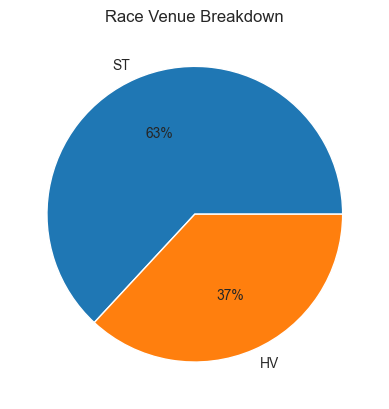

In [8]:
st_count = len(races_df[races_df['venue'] == 'ST'])
hv_count = len(races_df[races_df['venue'] == 'HV'])

plt.pie([st_count, hv_count], labels=['ST', 'HV'], autopct='%.0f%%')
plt.title('Race Venue Breakdown')
plt.show()

### Race Distances Distribution

Text(0.5, 1.0, 'Race Distance Distribution')

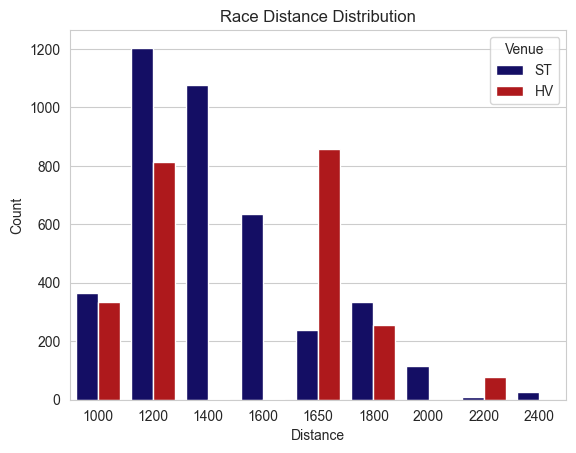

In [9]:
lengths_lst = list(set(races_df.distance))
lengths_lst.sort()

sns.countplot(data = races_df, x = 'distance', hue='venue',
              order = lengths_lst, palette="blend:#080072,#c70004")
plt.legend(title='Venue', loc='upper right', labels=['ST', 'HV'])

plt.xlabel('Distance')
plt.ylabel('Count')
plt.title('Race Distance Distribution')

The race distances are mostly in the 1200 to 1650 range with long races of 1800+ being quite rare.

### Goings Distribution

Text(0.5, 1.0, 'Going Distribution')

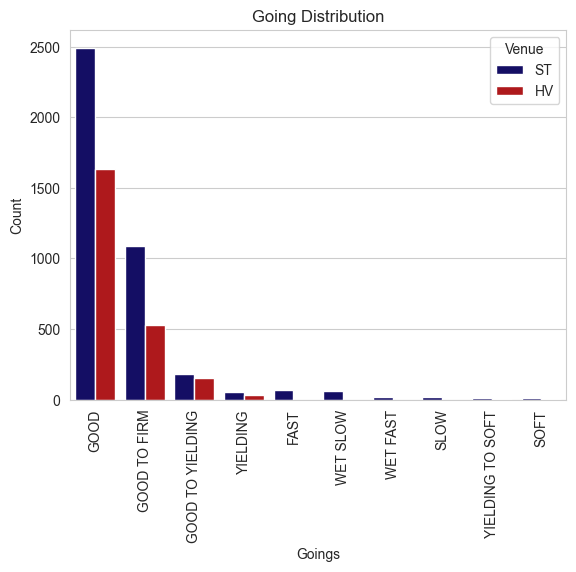

In [10]:
sns.countplot(data = races_df, x = 'going', hue='venue', palette="blend:#080072,#c70004",
              order = races_df.going.value_counts().index)
plt.legend(title='Venue', loc='upper right', labels=['ST', 'HV'])
plt.xticks(rotation=90)

plt.xlabel('Goings')
plt.ylabel('Count')
plt.title('Going Distribution')

The vast majority of the goings are some version of good goings. Later, models will show if an ordinal breakdown of these values can be useful predictors.

Get the number of sections for each race. This will come into play several times in feature engineering.

In [11]:
races_df['sections_n'] = races_df['sec_time4'].apply(lambda x: 3 if np.isnan(x) else 4)
races_df['sections_n'] = races_df.apply(lambda row: row['sections_n'] if np.isnan(row['sec_time5']) else 5, axis=1)
races_df['sections_n'] = races_df.apply(lambda row: row['sections_n'] if np.isnan(row['sec_time6']) else 6, axis=1)

### Race Section Distribution

Text(0.5, 1.0, 'Race Section Distribution')

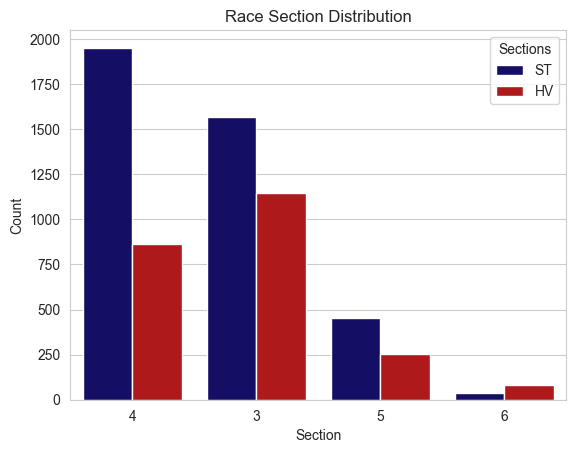

In [12]:
sns.countplot(data = races_df, x = 'sections_n', hue='venue', palette="blend:#080072,#c70004",
              order = races_df.sections_n.value_counts().index)
plt.legend(title='Sections', loc='upper right', labels=['ST', 'HV'])

plt.xlabel('Section')
plt.ylabel('Count')
plt.title('Race Section Distribution')

The most common number of sections in a race are 3 and 4, with 6 being exceptionally rare. Rather than using binary indicator variables to show if a section is applicable to a race, we can adjust these to make our own custom sections (beginning, middle, and end).

There are a variety of race distances leading to many nan values in the 'sec_time' and 'time' features for sections 4, 5, and 6. As a result, I chose to rearrange these to have beginning, middle, and end sections. The beginning section contains the values from section 1. The end section contains the values from the last section of the race. Lastly, the middle section is the mean of all section values between the first and last sections, exlusive. I also multiplied the values by the number of sections divided by the distance. This helps us get the time per distance in each section:

(time/section) * (section/distance) = (time/distance)

Apply the above transformation to the leader section finishing times. Also get the leader total race time as the sum of the leader times in each section. Note that this is not necessarily the same thing as the winner's total time, as the winner might not have led during each section. Instead, this calculation could give a lower (but never higher) value.

In [13]:
races_df['leader_time_beg'] = races_df.apply(lambda row: row['sec_time1'] * row['sections_n'] / row['distance'], axis=1)

races_df['leader_time_mid'] = races_df.apply(lambda row: np.mean([row['sec_time'+str(i+1)] for i in range(row['sections_n']-1)]) * \
                                                      (row['sections_n'] - 2) / row['distance'], axis=1)

races_df['leader_time_end'] = races_df.apply(lambda row: row['sec_time'+str(row['sections_n'])] * row['sections_n'] / row['distance'], axis=1)

races_df['leader_total_time'] = races_df.apply(lambda row: np.sum([row['sec_time'+str(i+1)] for i in range(row['sections_n'])]), axis=1)

Convert the nominal data into numeric values. This will be useful for machine learning models requiring numeric inputs.

In [14]:
# convert turf and dirt quality into ordinal data
turf_dict = {'FIRM':2, 'GOOD TO FIRM':1, 'GOOD':0, 'GOOD TO YIELDING':-1,
             'YIELDING':-2,'YIELDING TO SOFT':-3, 'SOFT':-4}
dirt_dict = {'FAST':1, 'WET FAST':1, 'GOOD':0, 'SLOW':-1, 'WET SLOW':-1}

# make wet conditions binary (1 for wet, 0 for not wet)
wet_dict = {'FIRM':0, 'GOOD TO FIRM':0, 'GOOD':0, 'GOOD TO YIELDING':0,
            'YIELDING':0, 'YIELDING TO SOFT':0, 'SOFT':0, 'FAST':0,
            'SLOW':0, 'WET FAST':1, 'WET SLOW':1}

# get Shatin track home straight distances
st_straight_dict = {'A':430, 'A+2':430, 'A+3':430, 'B':430,'B+2':430, 'C':430, 'C+3':430,
                    'NA':None, 'NA+2':None, 'NB':None, 'NB+2':None, 'AWT':365}

# get Shatin track track widths
st_width_dict = {'A':30.5, 'A+2':28.5, 'A+3':27.5, 'B':26,'B+2':24, 'C':21.3, 'C+3':18.3,
                 'NA':30.5, 'NA+2':28.5, 'NB':26, 'NB+2':24, 'AWT':22.8}

# get Happy Valley track home straight distances
hv_straight_dict = {'A':312, 'A+2':310, 'B':338, 'B+2':338, 'B+3':338,
                    'C':334, 'C+3':335}

# get Happy Valley track widths
hv_width_dict = {'A':30.5, 'A+2':28.5, 'B':26.5, 'B+2':24.5, 'B+3':23.5,
                 'C':22.5, 'C+3':19.5}

Use the dictionaries above to assign values to the races data. Additionally, convert other string data points into numeric values.

In [15]:
races_df['home_straight'] = races_df.apply(lambda row: st_straight_dict[row['config']] if row['venue'] == 'ST' else hv_straight_dict[row['config']], axis=1)
races_df['width'] = races_df.apply(lambda row: st_width_dict[row['config']] if row['venue'] == 'ST' else hv_width_dict[row['config']], axis=1)

races_df['surface_adj'] = races_df.apply(lambda row: turf_dict[row['going']] if not row['surface'] else dirt_dict[row['going']], axis=1)
races_df['wet'] = races_df.apply(lambda row: wet_dict[row['going']], axis=1)

In [16]:
# get upper range of horse ratings for the race
races_df['rating_range_high'] = races_df['horse_ratings'].apply(lambda x: x[:x.find('-')] if '-' in x else x)
races_df['rating_range_high'] = races_df['rating_range_high'].apply(lambda x: np.nan if '+' in x else x)

# get lower range of horse ratings for the race
races_df['rating_range_low'] = races_df['horse_ratings'].apply(lambda x: x[x.find('-')+1:] if '-' in x else x)
races_df['rating_range_low'] = races_df['rating_range_low'].apply(lambda x: x[0:-1] if '+' in x else x)

# make a binary variable for the gelding class and another for no max upper range
races_df['rating_range_type_g'] = races_df['rating_range_low'].apply(lambda x: 1 if x == 'G' else 0)
# if there is no upper max, set max value to nan
races_df['rating_range_type_no_max'] = races_df['rating_range_high'].apply(lambda x: 1 if x is np.nan else 0)

# if this is a gelding class, set upper and lower limits to nan
races_df['rating_range_low'] = races_df['rating_range_low'].apply(lambda x: np.nan if x == 'G' else x)
races_df['rating_range_high'] = races_df['rating_range_high'].apply(lambda x: np.nan if x == 'G' else x)

Convert date to year, month, and day values. Then apply sine/cosine function to the month values in case there are cyclical effects from the time of year, which could impact weather/temperature.

In [17]:
# convert date to DateTime object
races_df['date'] = races_df['date'].apply(lambda x: DT.datetime.strptime(x, '%Y-%m-%d'))

# make day, month, and year columns
races_df['year'] = races_df['date'].apply(lambda x: x.year)
races_df['month'] = races_df['date'].apply(lambda x: x.month)
races_df['day'] = races_df['date'].apply(lambda x: x.day)

In [18]:
# define the sine/cosine transformation function
def sine_cosine_trans(x, period):
    return math.sin((2 * math.pi * x)/period), math.cos((2 * math.pi * x)/period)

In [19]:
# apply the sine/cosine transformation to the month feature
races_df[['month_sin', 'month_cos']] = races_df.apply(lambda row: sine_cosine_trans(row['month'], 12), axis=1, result_type='expand')
races_df[['month_sin', 'month_cos']]

,month_sin,month_cos
0,1.224647e-16,-1.0
1,1.224647e-16,-1.0
2,1.224647e-16,-1.0
3,1.224647e-16,-1.0
4,1.224647e-16,-1.0
...,...,...
6344,-8.660254e-01,-0.5
6345,-8.660254e-01,-0.5
6346,-8.660254e-01,-0.5
6347,-8.660254e-01,-0.5


One hot encode the venue, configuration, horse type, and horse country features.

In [20]:
venues = races_df['venue']
configs = races_df['config']
# since all of these have values (none are nan), I'll drop the first feature
races_df = pd.get_dummies(races_df, columns = ['venue', 'config'], drop_first=True)
# since there are nan values for these, we'll keep the first letting nan values be the reference
runs_df = pd.get_dummies(runs_df, columns = ['horse_type', 'horse_country'])
races_df['venue'] = venues
races_df['config'] = configs

### Leader Section Times Box Plots

Text(0.5, 1.0, 'Leader Time Box Plots by Section and Venue')

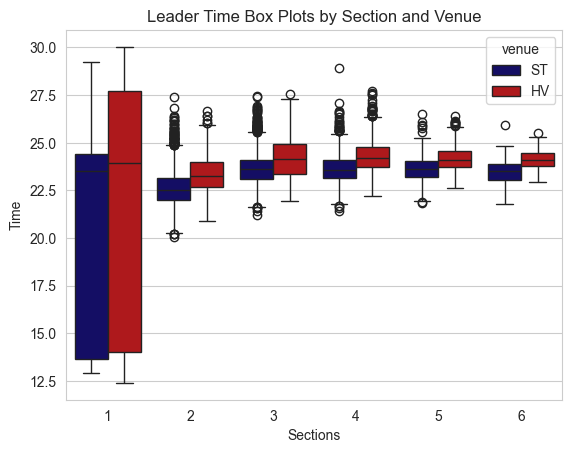

In [21]:
temp_df = races_df[['sec_time1', 'sec_time2', 'sec_time3', 'sec_time4', 'sec_time5', 'sec_time6', 'venue']]
temp_df = pd.concat([temp_df[['sec_time1', 'venue']], temp_df[['sec_time2', 'venue']], temp_df[['sec_time3', 'venue']],
                     temp_df[['sec_time4', 'venue']], temp_df[['sec_time5', 'venue']], temp_df[['sec_time6', 'venue']]])

sections = []
for i in range(1, 7):
    sections.extend([i]*(len(temp_df)//6))

venues = temp_df['venue']
temp_df = temp_df.drop(columns=['venue']).sum(axis=1, numeric_only=True)
temp_df = pd.DataFrame(temp_df, columns=['time'])
temp_df['venue'] = venues
temp_df['section'] = sections
temp_df = temp_df[temp_df['time'] != 0]

sns.boxplot(data=temp_df, x="section", y="time", hue='venue', palette="blend:#080072,#c70004")
plt.xlabel('Sections')
plt.ylabel('Time')
plt.title('Leader Time Box Plots by Section and Venue')

We can see that the section 1 times vary a lot. These are likely not all of equal length. This will need to be addressed.

### Leader Custom Section Time Box Plots

Text(0.5, 1.0, 'Leader Time Box Plots by Custom Section and Venue')

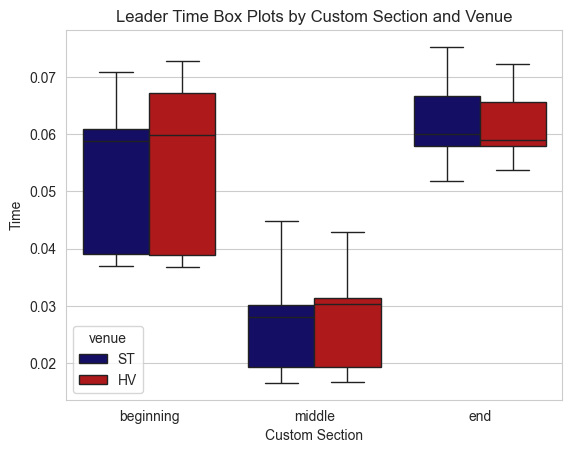

In [22]:
temp_df = races_df[['leader_time_beg', 'leader_time_mid', 'leader_time_end', 'venue']]
temp_df = pd.concat([temp_df[['leader_time_beg', 'venue']], temp_df[['leader_time_mid', 'venue']], temp_df[['leader_time_end', 'venue']]])

sections = []
for i in ['beginning', 'middle', 'end']:
    sections.extend([i]*(len(temp_df)//3))

# temp_df['sections'] = sections
venues = temp_df['venue']
temp_df = temp_df.drop(columns=['venue']).sum(axis=1, numeric_only=True)
temp_df = pd.DataFrame(temp_df, columns=['time'])
temp_df['venue'] = venues
temp_df['section'] = sections
temp_df = temp_df[temp_df['time'] != 0]

sns.boxplot(data=temp_df, x="section", y="time", hue='venue', palette="blend:#080072,#c70004")
plt.xlabel('Custom Section')
plt.ylabel('Time')
plt.title('Leader Time Box Plots by Custom Section and Venue')

The section transformation has decreased the variance in the beginning section (previously called section 1). It's not surprising that the beginning and end sections are slower as horses start the race from a standstill and are likely to be more tired by the final section (some may even be injured and therefore slower down the stretch).

## Merge Runs and Subset of Races Dataframes

In [23]:
races_df.columns

Index(['race_id', 'date', 'race_no', 'surface', 'distance', 'going',
       'horse_ratings', 'prize', 'race_class', 'sec_time1', 'sec_time2',
       'sec_time3', 'sec_time4', 'sec_time5', 'sec_time6', 'time1', 'time2',
       'time3', 'time4', 'time5', 'time6', 'place_combination1',
       'place_combination2', 'place_combination3', 'place_combination4',
       'place_dividend1', 'place_dividend2', 'place_dividend3',
       'place_dividend4', 'win_combination1', 'win_dividend1',
       'win_combination2', 'win_dividend2', 'sections_n', 'leader_time_beg',
       'leader_time_mid', 'leader_time_end', 'leader_total_time',
       'home_straight', 'width', 'surface_adj', 'wet', 'rating_range_high',
       'rating_range_low', 'rating_range_type_g', 'rating_range_type_no_max',
       'year', 'month', 'day', 'month_sin', 'month_cos', 'venue_ST',
       'config_A+3', 'config_B', 'config_B+2', 'config_C', 'config_C+3',
       'venue', 'config'],
      dtype='object')

Prior to merging, I'm picking out the features that could feasibly be useful in predicting finishing times.

In [24]:
races_merge_df = races_df[['race_id', 'race_no', 'month_sin', 'month_cos', 'year', 'venue', 'config', 'distance', 'surface_adj',
                           'wet', 'race_class', 'home_straight', 'width', 'leader_time_beg', 'leader_time_mid', 'leader_time_end',
                           'leader_total_time', 'place_combination1', 'place_combination2', 'place_combination3',
                           'place_combination4', 'place_dividend1', 'place_dividend2', 'place_dividend3', 'place_dividend4',
                           'win_combination1', 'win_combination2', 'win_dividend1', 'win_dividend2', 'rating_range_high',
                           'rating_range_low', 'rating_range_type_g', 'rating_range_type_no_max', 'venue_ST', 'config_A+3',
                           'config_B', 'config_B+2', 'config_C', 'config_C+3', 'sections_n']]

In [25]:
# we only miss out on one right_only match when 'inner' matching
# this is because there isn't any horse data for race id #6108
runs_full_df = runs_df.merge(races_merge_df, how='inner', on='race_id')
runs_full_df

,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_rating,horse_gear,declared_weight,...,rating_range_low,rating_range_type_g,rating_range_type_no_max,venue_ST,config_A+3,config_B,config_B+2,config_C,config_C+3,sections_n
0,0,1,3917,10,0.0,8.00,3,60,--,1020.0,...,15,0,0,True,False,False,False,False,False,4
1,0,2,2157,8,0.0,5.75,3,60,--,980.0,...,15,0,0,True,False,False,False,False,False,4
2,0,3,858,7,0.0,4.75,3,60,--,1082.0,...,15,0,0,True,False,False,False,False,False,4
3,0,4,1853,9,0.0,6.25,3,60,--,1118.0,...,15,0,0,True,False,False,False,False,False,4
4,0,5,2796,6,0.0,3.75,3,60,--,972.0,...,15,0,0,True,False,False,False,False,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79442,6348,10,1238,6,0.0,1.25,5,87,TT/V,1191.0,...,80,0,0,True,False,False,False,False,False,4
79443,6348,11,985,7,0.0,2.25,5,84,--,1070.0,...,80,0,0,True,False,False,False,False,False,4
79444,6348,12,3147,10,0.0,3.00,5,83,H/XB,1148.0,...,80,0,0,True,False,False,False,False,False,4
79445,6348,13,1982,8,0.0,2.50,3,82,--,1266.0,...,80,0,0,True,False,False,False,False,False,4


## Cleaning/Exploring Merged Runs

Some values appear as 999, which is an extreme outlier. My assumption is that these are missing values. I'll assign nan to columns containing at least one of these (these columns are known from running the describe method on the dataframe.

In [26]:
list_to_correct = ['position_sec1', 'position_sec2', 'position_sec3', 'position_sec4', 'position_sec5', 'position_sec6',
                   'behind_sec1', 'behind_sec2', 'behind_sec3', 'behind_sec4', 'behind_sec5', 'behind_sec6',
                   'time1', 'time2', 'time3', 'time4', 'time5', 'time6', 'lengths_behind']

for i in list_to_correct:
    runs_df[i] = runs_df[i].apply(lambda x: np.nan if x == 999 else x)
    runs_full_df[i] = runs_full_df[i].apply(lambda x: np.nan if x == 999 else x)

Convert the 6 time, position, and behind features into our new version of 3 time, position, and behind features – one for the first section, another for the last, and a final for the middle sections. These changes follow a similar process to a previous calculation on the races dataframe.

In [27]:
runs_full_df['time_beg'] = runs_full_df.apply(lambda row: row['time1'] * row['sections_n'] / row['distance'], axis=1)

runs_full_df['time_mid'] = runs_full_df.apply(lambda row: np.mean([row['time'+str(i+1)] for i in range(row['sections_n']-1)]) * \
                                                      (row['sections_n'] - 2) / row['distance'], axis=1)

runs_full_df['time_end'] = runs_full_df.apply(lambda row: row['time'+str(row['sections_n'])] * row['sections_n'] / row['distance'], axis=1)


runs_full_df['position_beg'] = runs_full_df['position_sec1']
runs_full_df['position_mid'] = runs_full_df.apply(lambda row: np.mean([row['position_sec'+str(i+1)] for i in range(row['sections_n']-1)]), axis=1)
runs_full_df['position_end'] = runs_full_df.apply(lambda row: row['position_sec'+str(row['sections_n'])], axis=1)


runs_full_df['behind_beg'] = runs_full_df['behind_sec1']
runs_full_df['behind_mid'] = runs_full_df.apply(lambda row: np.mean([row['behind_sec'+str(i+1)] for i in range(row['sections_n']-1)]), axis=1)
runs_full_df['behind_end'] = runs_full_df.apply(lambda row: row['behind_sec'+str(row['sections_n'])], axis=1)

Make an adjusted finish time feature that shows the time as a fraction of the race distance. Additionally, make a feature for the finish time as a fraction of the leader total time. Recall, that the leader total time is not necessarily the finishing time of the race winner, but rather the sum of the section times of each leade. This sum can be less than or equal to, but never greater than the winner's finish time.

In [28]:
runs_full_df['finish_time_adj'] = runs_full_df.apply(lambda row: row['finish_time'] / row['distance'], axis=1)

runs_full_df['finish_time_behind_perc'] = runs_full_df.apply(lambda row: (row['finish_time'] - row['leader_total_time'])
                                                                         / row['leader_total_time'], axis=1)

### All Horses Section Times Box Plots

Text(0.5, 1.0, 'Time Box Plots by Section and Venue')

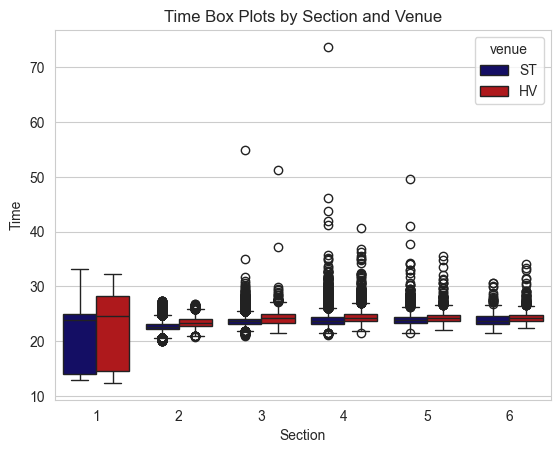

In [29]:
temp_df = runs_full_df[['time1', 'time2', 'time3', 'time4', 'time5', 'time6', 'venue']]
temp_df = pd.concat([temp_df[['time1', 'venue']], temp_df[['time2', 'venue']], temp_df[['time3', 'venue']],
                     temp_df[['time4', 'venue']], temp_df[['time5', 'venue']], temp_df[['time6', 'venue']]])

sections = []
for i in range(1, 7):
    sections.extend([i]*(len(temp_df)//6))

# temp_df['sections'] = sections
venues = temp_df['venue']
temp_df = temp_df.drop(columns=['venue']).sum(axis=1, numeric_only=True)
temp_df = pd.DataFrame(temp_df, columns=['time'])
temp_df['venue'] = venues
temp_df['section'] = sections
temp_df = temp_df[temp_df['time'] != 0]

sns.boxplot(data=temp_df, x="section", y="time", hue='venue', palette="blend:#080072,#c70004")
plt.xlabel('Section')
plt.ylabel('Time')
plt.title('Time Box Plots by Section and Venue')

As seen with the leaders section times, there is still more variance in section 1 prior to my adjustments.

Now that new sections have been defined, remove the older, un-engineered variants.

In [30]:
runs_full_df = runs_full_df.drop(columns=['position_sec1', 'position_sec2', 'position_sec3', 'position_sec4', 'position_sec5', 'position_sec6',
                                          'behind_sec1', 'behind_sec2', 'behind_sec3', 'behind_sec4', 'behind_sec5', 'behind_sec6',
                                          'time1', 'time2', 'time3', 'time4', 'time5', 'time6'])

### All Horses Custom Section Times Box Plots

Text(0.5, 1.0, 'Time Box Plots by Custom Section and Venue')

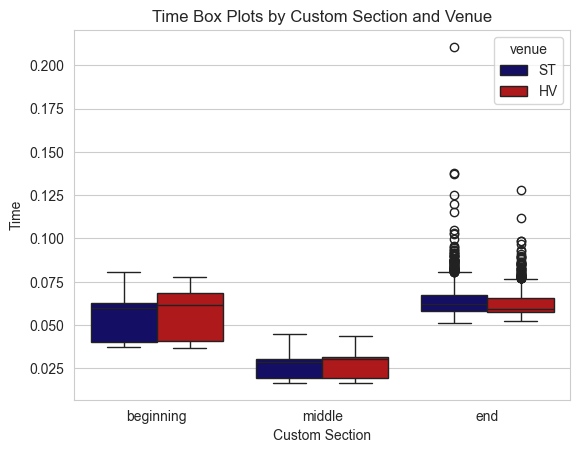

In [31]:
temp_df = runs_full_df[['time_beg', 'time_mid', 'time_end', 'venue']]
temp_df = pd.concat([temp_df[['time_beg', 'venue']], temp_df[['time_mid', 'venue']], temp_df[['time_end', 'venue']]])

sections = []
for i in ['beginning', 'middle', 'end']:
    sections.extend([i]*(len(temp_df)//3))

venues = temp_df['venue']
temp_df = temp_df.drop(columns=['venue']).sum(axis=1, numeric_only=True)
temp_df = pd.DataFrame(temp_df, columns=['time'])
temp_df['venue'] = venues
temp_df['section'] = sections
temp_df = temp_df[temp_df['time'] != 0]

sns.boxplot(data=temp_df, x="section", y="time", hue='venue', palette="blend:#080072,#c70004")
plt.xlabel('Custom Section')
plt.ylabel('Time')
plt.title('Time Box Plots by Custom Section and Venue')

After my adjustments, the beginning section has a much smaller variance.

In [32]:
runs_full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79447 entries, 0 to 79446
Data columns (total 92 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   race_id                   79447 non-null  int64  
 1   horse_no                  79447 non-null  int64  
 2   horse_id                  79447 non-null  int64  
 3   result                    79447 non-null  int64  
 4   won                       79447 non-null  float64
 5   lengths_behind            79358 non-null  float64
 6   horse_age                 79447 non-null  int64  
 7   horse_rating              79447 non-null  int64  
 8   horse_gear                79447 non-null  object 
 9   declared_weight           79447 non-null  float64
 10  actual_weight             79447 non-null  int64  
 11  draw                      79447 non-null  int64  
 12  finish_time               79447 non-null  float64
 13  win_odds                  79447 non-null  float64
 14  place_

Make predictive binary features to flag nan values so that we can set these values to 0 (if applicable) later while retaining information about them originally being null. If there are only a few nan values, we will drop these later. Also, some of these columns like place_combination3 will not be used as a feature. Therefore, we refrain from making a binary null indicator for these.

In [33]:
runs_full_df['lengths_behind_isnan'] = runs_full_df['lengths_behind'].apply(lambda x: True if np.isnan(x) else False)
runs_full_df['place_odds_isnan'] = runs_full_df['place_odds'].apply(lambda x: True if np.isnan(x) else False)

Get the horse weights separate from the jockey, and use this to get a percentage of weight carried by the horse compared to its own body weight.

In [34]:
runs_full_df['horse_weight'] = runs_full_df['declared_weight'] - runs_full_df['actual_weight']
runs_full_df['carried_weight_perc'] = runs_full_df['actual_weight'] / runs_full_df['horse_weight']

Make binary columns for each horse gear item. This would have been used in clustering.

In [35]:
runs_full_df['horse_gear_split'] = runs_full_df['horse_gear'].apply(lambda x: x.split('/'))
temp = runs_full_df.explode(column=['horse_gear_split'])

Get the average number of races per horse.

In [36]:
temp = runs_df.groupby('horse_id').count()
np.mean(temp['result'])

18.035641316685584

## Make Rolling Averages

Define a function to get the rolling average of a given feature with a window size of 3. If there aren't 3 previous instances, it will try 2, and then 1. In future implimentations, a weighting rolling average could also be implemented.

In [37]:
def rolling(df, column):

    # df[column + '_rolling_4_count'] = \
    #     df.groupby('horse_id')[column].transform(lambda x: x.rolling(window=4, closed='left').count())

    # get counts for 1, 2, and 3 sized windows respectively
    df[column + '_rolling_3_count'] = \
        df.groupby('horse_id')[column].transform(lambda x: x.rolling(window=3, closed='left').count())

    df[column + '_rolling_2_count'] = \
        df.groupby('horse_id')[column].transform(lambda x: x.rolling(window=2, closed='left').count())

    df[column + '_rolling_1_count'] = \
        df.groupby('horse_id')[column].transform(lambda x: x.rolling(window=1, closed='left').count())

    df[column+'_adj'] = df[column].fillna(0)

    # df[column + '_rolling_4_sum'] = \
    #     df.groupby('horse_id')[column+'_adj'].transform(lambda x: x.rolling(window=4, closed='left').sum())

    # take the sum of 1, 2, and 3 sized windows respectively
    df[column + '_rolling_3_sum'] = \
        df.groupby('horse_id')[column+'_adj'].transform(lambda x: x.rolling(window=3, closed='left').sum())

    df[column + '_rolling_2_sum'] = \
        df.groupby('horse_id')[column+'_adj'].transform(lambda x: x.rolling(window=2, closed='left').sum())

    df[column + '_rolling_1_sum'] = \
        df.groupby('horse_id')[column+'_adj'].transform(lambda x: x.rolling(window=1, closed='left').sum())

    # calculate the average of 1, 2, and 3 sized windows respectively (i.e. sum/count)
    # df[column + '_rolling_4_mean'] = df[column + '_rolling_4_sum'] / df[column + '_rolling_4_count']
    df[column + '_rolling_3_mean'] = df[column + '_rolling_3_sum'] / df[column + '_rolling_3_count']
    df[column + '_rolling_2_mean'] = df[column + '_rolling_2_sum'] / df[column + '_rolling_2_count']
    df[column + '_rolling_1_mean'] = df[column + '_rolling_1_sum'] / df[column + '_rolling_1_count']

    # try to set a window of size 2, but if not use the size 1 window value
    df[column + '_rolling_2_mean'] = df.apply(lambda row: row[column + '_rolling_1_mean'] \
        if np.isnan(row[column + '_rolling_2_mean']) else row[column + '_rolling_2_mean'], axis=1)

    # try to set a window of size 3, but if not use the size 2 window value (which was update to be 1 if necessary)
    df[column + '_rolling'] = df.apply(lambda row: row[column + '_rolling_2_mean'] \
        if np.isnan(row[column + '_rolling_3_mean']) else row[column + '_rolling_3_mean'], axis=1)

    # df[column + '_rolling_3_mean'] = df.apply(lambda row: row[column + '_rolling_2_mean'] \
    #     if np.isnan(row[column + '_rolling_3_mean']) else row[column + '_rolling_3_mean'], axis=1)

    # df[column + '_rolling'] = df.apply(lambda row: row[column + '_rolling_3_mean'] \
    #     if np.isnan(row[column + '_rolling_4_mean']) else row[column + '_rolling_4_mean'], axis=1)

    # drop the intermediate columns used in the calculations
    df = df.drop(columns=[column + '_rolling_1_count', column + '_rolling_1_sum', column + '_rolling_1_mean',
                          column + '_rolling_2_count', column + '_rolling_2_sum', column + '_rolling_2_mean',
                          column + '_rolling_3_count', column + '_rolling_3_sum',

                          # column + '_rolling_4_count', column + '_rolling_4_sum',
                          # column + '_rolling_1_mean', column + '_rolling_2_mean',
                          # column + '_rolling_3_mean', column + '_rolling_4_mean',
                          column+'_adj'])

    return df

Call the rolling function on features whose previous values could plausibly serve as future predictors of performance. Additionally, we make a distance difference feature to see how each horse's previous race distances compare to the current race distance. Perhaps, a horse is used to running in shorter length races, and is attempting a much longer one. Finally, make a binary feature taking on a value of 1 when there isn't any rolling data for this horse. This value aligns with all but 'behind_end_rolling' and 'lengths_behind_rolling' which are missing in 12 more instances. We'll replace these in a few cells down, while also addressing the nan values in their non-rolling variants.

In [38]:
runs_full_df = rolling(runs_full_df, 'time_beg')
runs_full_df = rolling(runs_full_df, 'time_mid')
runs_full_df = rolling(runs_full_df, 'time_end')
runs_full_df = rolling(runs_full_df, 'position_beg')
runs_full_df = rolling(runs_full_df, 'position_mid')
runs_full_df = rolling(runs_full_df, 'position_end')
runs_full_df = rolling(runs_full_df, 'behind_beg')
runs_full_df = rolling(runs_full_df, 'behind_mid')
runs_full_df = rolling(runs_full_df, 'behind_end')

runs_full_df = rolling(runs_full_df, 'finish_time_adj')
runs_full_df = rolling(runs_full_df, 'finish_time_behind_perc')
runs_full_df = rolling(runs_full_df, 'lengths_behind')
runs_full_df = rolling(runs_full_df, 'result')

runs_full_df = rolling(runs_full_df, 'surface_adj')
runs_full_df = rolling(runs_full_df, 'distance')

# make feature showing the difference between the horse's rolling average distance and the distance of this race
runs_full_df['distance_diff'] = runs_full_df['distance_rolling'] - runs_full_df['distance']

runs_full_df['rolling_isnan'] = runs_full_df['time_beg_rolling'].apply(lambda x: True if np.isnan(x) else False)
# runs_full_df['sec_mid_rolling_isnan'] = runs_full_df['time_mid'].apply(lambda x: True if np.isnan(x) else False)
# runs_full_df['sec_end_rolling_isnan'] = runs_full_df['time_end'].apply(lambda x: True if np.isnan(x) else False)

Inspect the rolling metric and the underlying features that generated them.

In [39]:
runs_full_df[['race_no',
              'time_beg', 'time_mid', 'time_end',
              'position_beg', 'position_mid', 'position_end',
              'behind_beg', 'behind_mid', 'behind_end',

              'time_beg_rolling', 'time_mid_rolling', 'time_end_rolling',
              'position_beg_rolling', 'position_mid_rolling', 'position_end_rolling',
              'behind_beg_rolling', 'behind_mid_rolling', 'behind_end_rolling',
              'finish_time_adj_rolling', 'finish_time_behind_perc_rolling',
              'lengths_behind_rolling', 'result_rolling', 'surface_adj_rolling',
              'distance_rolling'
              ]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79447 entries, 0 to 79446
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   race_no                          79447 non-null  int64  
 1   time_beg                         79446 non-null  float64
 2   time_mid                         79445 non-null  float64
 3   time_end                         79446 non-null  float64
 4   position_beg                     79447 non-null  int64  
 5   position_mid                     79447 non-null  float64
 6   position_end                     79447 non-null  float64
 7   behind_beg                       79446 non-null  float64
 8   behind_mid                       79445 non-null  float64
 9   behind_end                       79358 non-null  float64
 10  time_beg_rolling                 75042 non-null  float64
 11  time_mid_rolling                 75042 non-null  float64
 12  time_end_rolling  

# Regression

## Make Regression dataframe

Among a few of these features, remove races in which any of these features have nan values. This only removed a couple of races.

In [40]:
# remove rows that are missing any of these features
# we only lose a couple
nan_race_ids = list(set(runs_full_df[runs_full_df[['time_beg', 'time_mid', 'time_end',
                                                   'position_beg', 'position_mid', 'position_end',
                                                   'behind_beg', 'behind_mid',
                                                   ]].isna().any(axis=1)]['race_id']))

removed_runs_full_df = runs_full_df[runs_full_df['race_id'].apply(lambda x: x not in nan_race_ids)]
print('Number of races removed:', len(nan_race_ids))
print('------------------------------------------------------------')

# make the regression dataframe using the below features
regr_df = removed_runs_full_df[['finish_time', 'win_odds', 'month_sin', 'month_cos', 'year',
                                'horse_age', 'horse_rating', 'horse_weight', 'carried_weight_perc',
                                'distance', 'home_straight', 'width', 'wet', 'draw', 'distance_diff', 'venue_ST',
                                'time_beg_rolling', 'time_mid_rolling', 'time_end_rolling',
                                'position_beg_rolling', 'position_mid_rolling', 'position_end_rolling',
                                'behind_beg_rolling', 'behind_mid_rolling',
                                'finish_time_adj_rolling',
                                'finish_time_behind_perc_rolling',
                                'result_rolling', 'distance_rolling', 'rolling_isnan',
                                'rating_range_high', 'rating_range_low', 'rating_range_type_g',
                                'rating_range_type_no_max',
                                'race_no',
                                'config_B',
                                'config_B+2', 'config_C', 'config_C+3',
                                ]]

# inspect the new dataframe null values
# the rolling values all have more nulls, but there's a binary variable
# to pick this up
regr_df.info()

Number of races removed: 2
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 79421 entries, 0 to 79446
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   finish_time                      79421 non-null  float64
 1   win_odds                         79421 non-null  float64
 2   month_sin                        79421 non-null  float64
 3   month_cos                        79421 non-null  float64
 4   year                             79421 non-null  int64  
 5   horse_age                        79421 non-null  int64  
 6   horse_rating                     79421 non-null  int64  
 7   horse_weight                     79421 non-null  float64
 8   carried_weight_perc              79421 non-null  float64
 9   distance                         79421 non-null  int64  
 10  home_straight                    79421 non-null  int64  
 1

It looks good. All rows with null values have binary indicator variables to pass on this information.

## Regression Correlation Matrix

Inspect regression dataframe's correlation matrix to see which variables could potentially be removed, and which look to be the best predictors – most correlated with the target 'finish_time' variable.

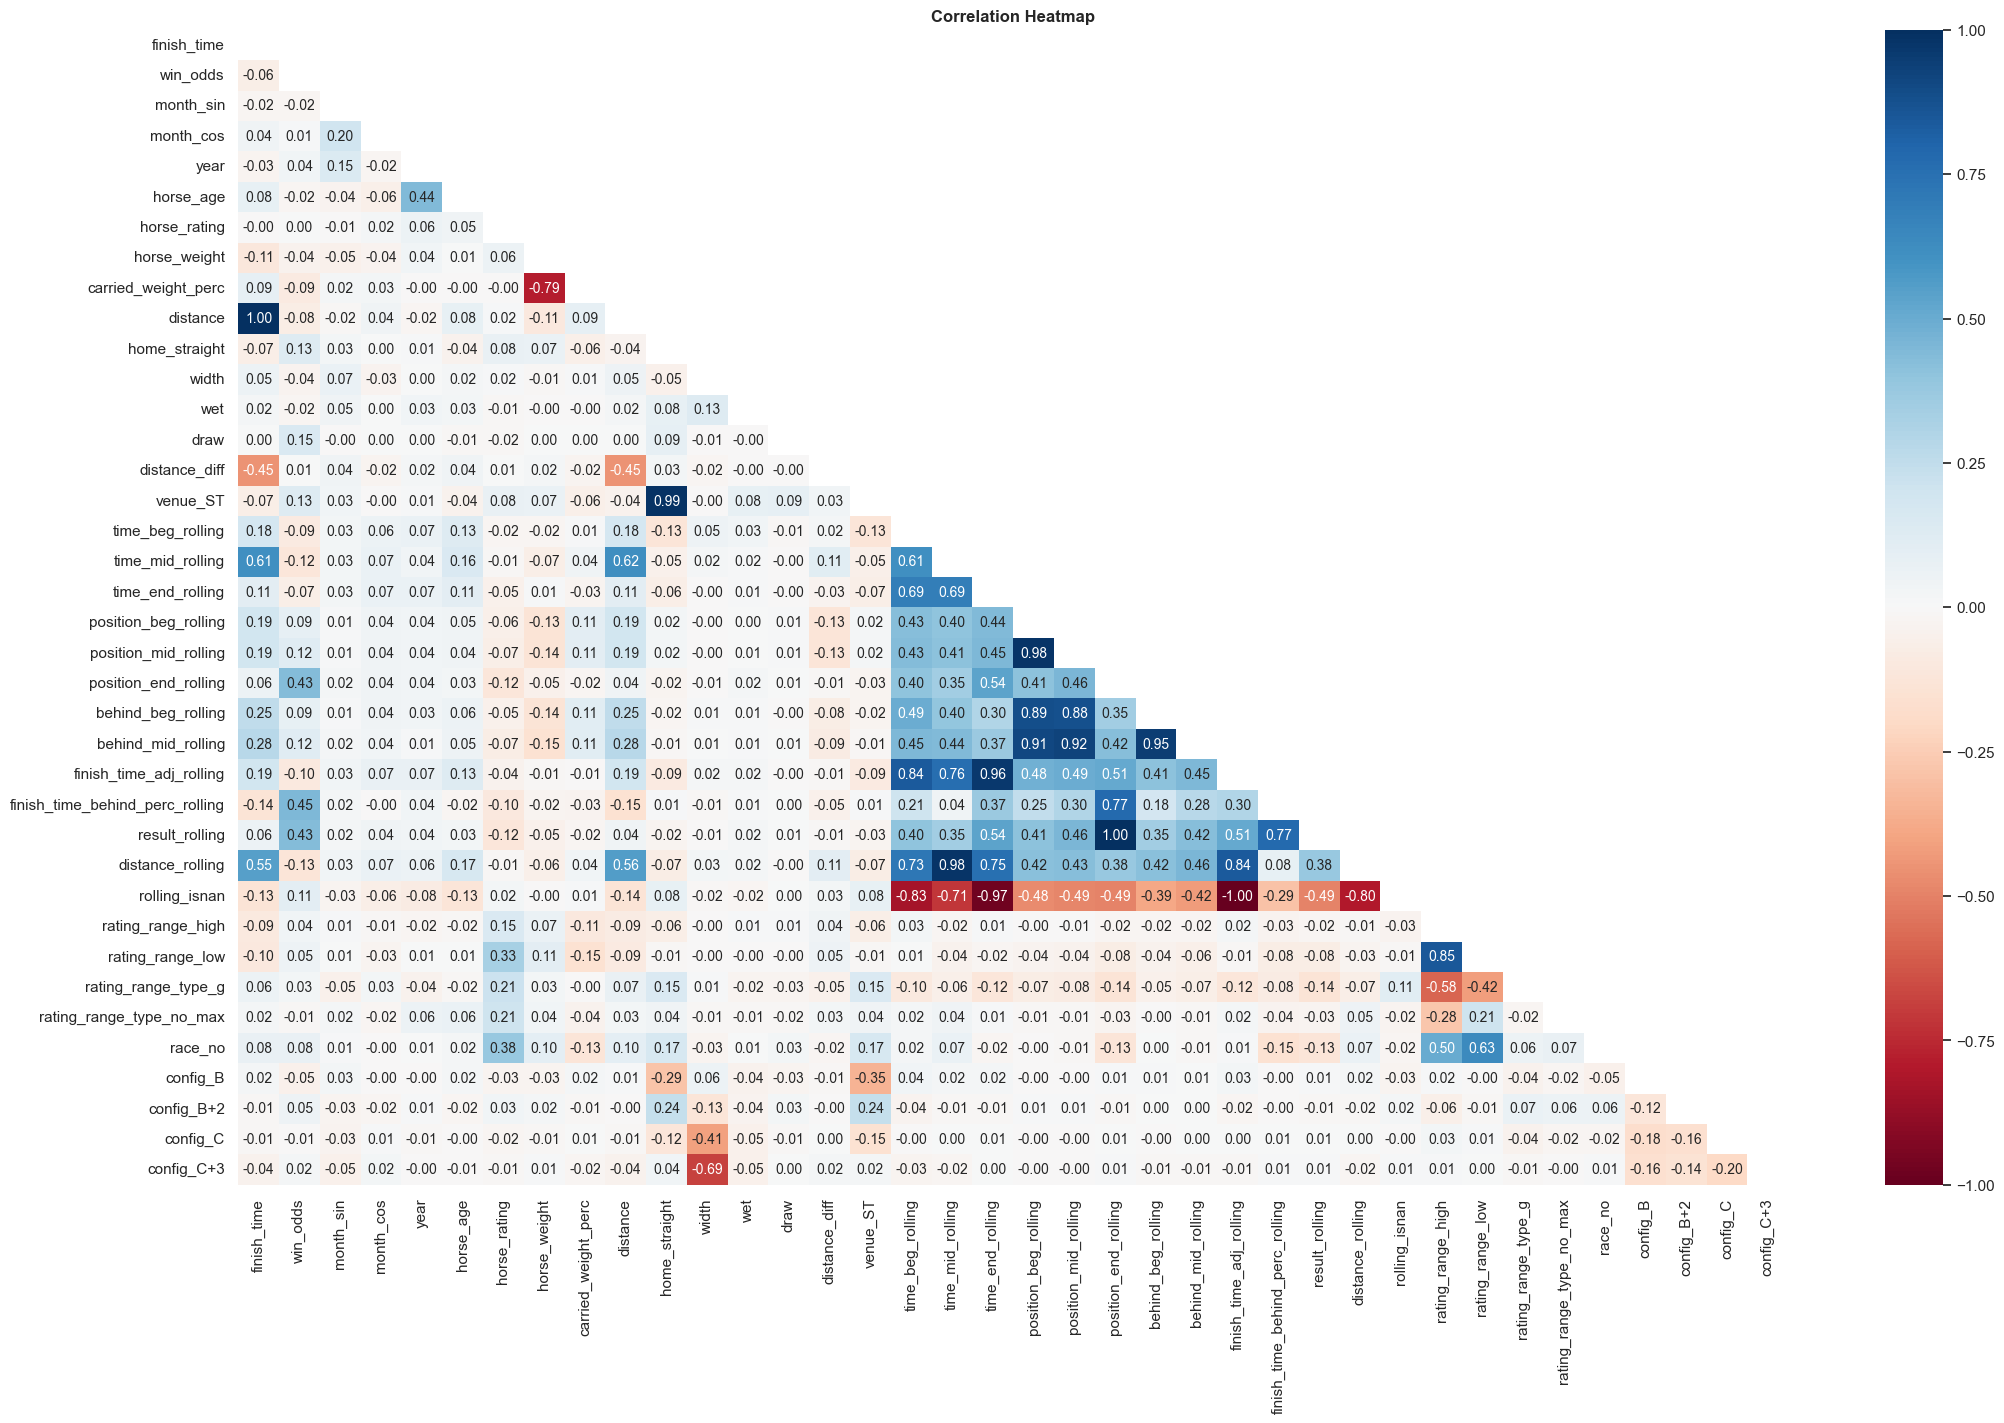

In [41]:
sns.set(style = "white")
plt.figure(figsize=(25,15))
corr_matrix = regr_df.fillna(0).corr()
mask = np.triu(np.ones_like(corr_matrix))
sns.heatmap(corr_matrix, cmap="RdBu", vmax=1, vmin = -1, annot = True, annot_kws={"size": 10}, fmt='.2f', mask=mask)
plt.title("Correlation Heatmap", fontweight='bold')
plt.show()

Highly Correlated Values (not including 'finish_time' target variable):

- venue_ST & home_straight
    - keep home_straight as these are unique to each venue anyway
    - remove venue_ST
- position_mid_rolling & position_beg_rolling
    - average the 2 to get position_mid_beg_rolling
    - remove position_mid_rolling
    - remove position_beg_rolling
- finish_time_adj_rolling & time_end_rolling
    - keep both
- behind_mid_rolling & behind_beg_rolling
    - keep both
- finish_time_adj_rolling & time_end_rolling
    - keep both
- result_rolling & position_end_rolling
    - keep results_rolling as these are essentially the same thing
    - remove position_end_rolling
- distance_rolling & time_mid_rolling
    - keep time_mid_rolling
    - remove distance_rolling
- rolling_isnan & time_end_rolling
    - keep both as one is a binary isnan check
- rolling_isnan & finish_time_adj_rolling
    - keep both as one is a binary isnan check

Apply the changes outlined above.

In [42]:
regr_df['position_mid_beg_rolling'] = regr_df.apply(lambda row: (row['position_beg_rolling'] + row['position_mid_rolling']) / 2, axis=1)
runs_full_df['position_mid_beg_rolling'] = runs_full_df.apply(lambda row: (row['position_beg_rolling'] + row['position_mid_rolling']) / 2, axis=1)

regr_df = regr_df.drop(columns=['venue_ST', 'position_mid_rolling', 'position_beg_rolling', 'position_end_rolling',
                                'distance_rolling'])
regr_df

/var/folders/9y/flvy6tfd14v8rmvfr2c0fry40000gn/T/ipykernel_58461/3355187713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regr_df['position_mid_beg_rolling'] = regr_df.apply(lambda row: (row['position_beg_rolling'] + row['position_mid_rolling']) / 2, axis=1)


,finish_time,win_odds,month_sin,month_cos,year,horse_age,horse_rating,horse_weight,carried_weight_perc,distance,...,rating_range_high,rating_range_low,rating_range_type_g,rating_range_type_no_max,race_no,config_B,config_B+2,config_C,config_C+3,position_mid_beg_rolling
0,83.92,9.7,1.224647e-16,-1.0,1997,3,60,887.0,0.149944,1400,...,40,15,0,0,1,False,False,False,False,NaN
1,83.56,16.0,1.224647e-16,-1.0,1997,3,60,847.0,0.157025,1400,...,40,15,0,0,1,False,False,False,False,NaN
2,83.40,3.5,1.224647e-16,-1.0,1997,3,60,950.0,0.138947,1400,...,40,15,0,0,1,False,False,False,False,NaN
3,83.62,39.0,1.224647e-16,-1.0,1997,3,60,991.0,0.128153,1400,...,40,15,0,0,1,False,False,False,False,NaN
4,83.24,50.0,1.224647e-16,-1.0,1997,3,60,841.0,0.155767,1400,...,40,15,0,0,1,False,False,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79442,96.17,99.0,-8.660254e-01,-0.5,2005,5,87,1069.0,0.114125,1600,...,100,80,0,0,10,False,False,False,False,9.333333
79443,96.30,99.0,-8.660254e-01,-0.5,2005,5,84,951.0,0.125131,1600,...,100,80,0,0,10,False,False,False,False,7.083333
79444,96.44,99.0,-8.660254e-01,-0.5,2005,5,83,1028.0,0.116732,1600,...,100,80,0,0,10,False,False,False,False,11.111111
79445,96.34,4.6,-8.660254e-01,-0.5,2005,3,82,1147.0,0.103749,1600,...,100,80,0,0,10,False,False,False,False,9.750000


Check the new matrix. It looks good!

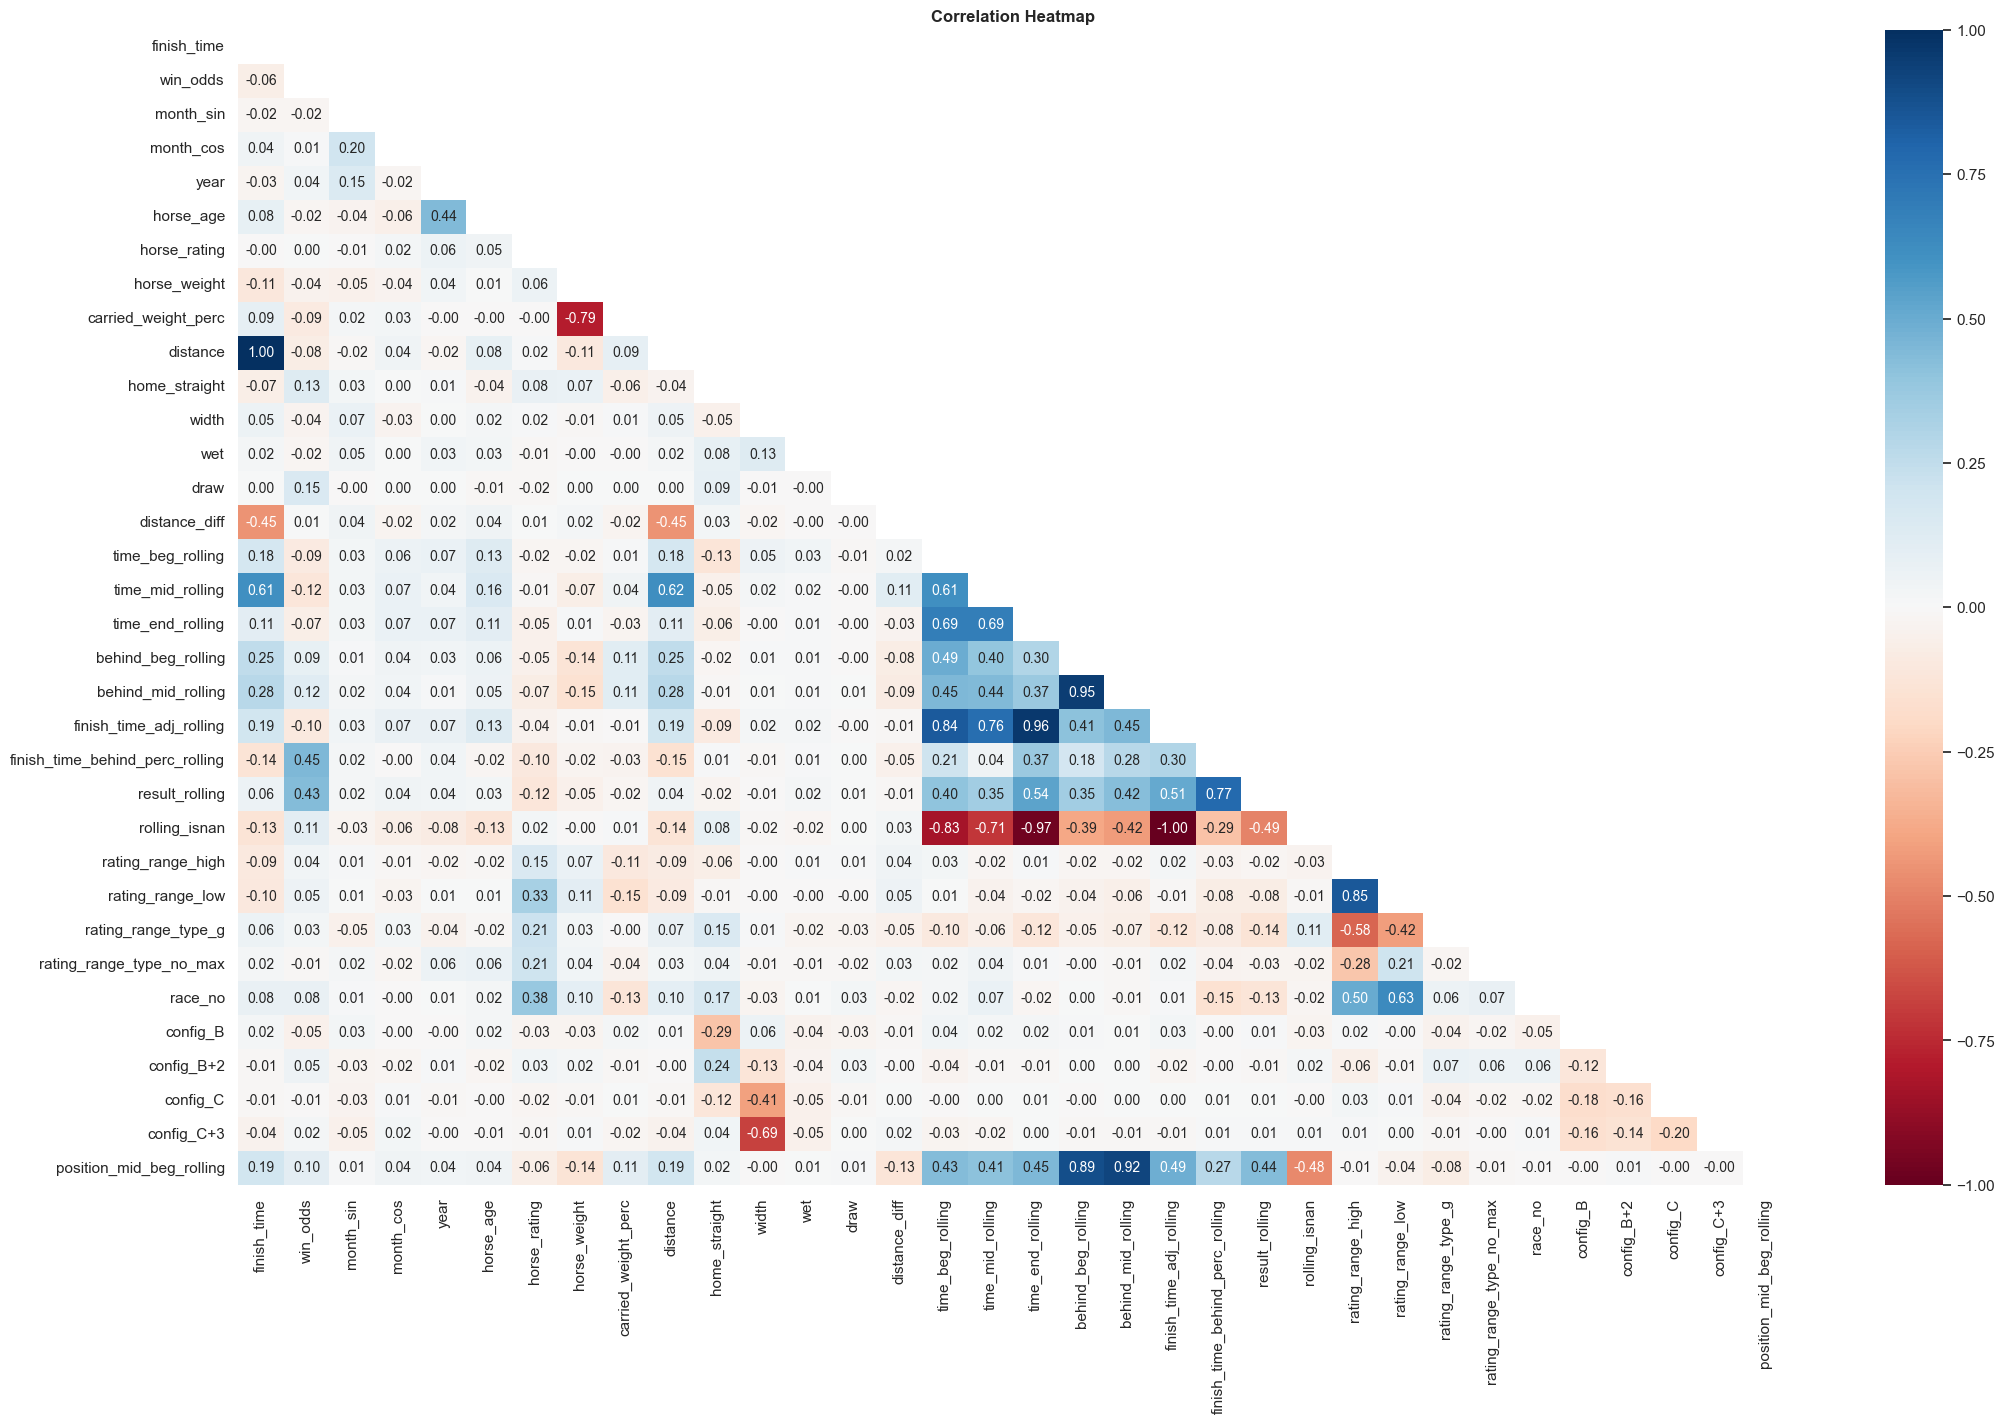

In [43]:
sns.set(style = "white")
plt.figure(figsize=(25,15))
corr_matrix = regr_df.fillna(0).corr()
mask = np.triu(np.ones_like(corr_matrix))
sns.heatmap(corr_matrix, cmap="RdBu", vmax=1, vmin = -1, annot = True, annot_kws={"size": 10}, fmt='.2f', mask=mask)
plt.title("Correlation Heatmap", fontweight='bold')
plt.show()

### Get X and y Data

In [44]:
runs_y = regr_df['finish_time']
runs_X = regr_df.drop(columns=['finish_time'])

## Baseline

Make the baseline finishing time predictor, which guesses the average time by race distance. First, we'll need to split the data into training and testing splits. The former will serve as the races to average over finishing times by distance. These will then serve as the predictor values in the testing data. Notice that by using a random state, we can ensure that the models are evaluated on the same data later for comparison.

In [45]:
# 80/20 train-test split
x_train, x_test, y_train, y_test = train_test_split(runs_X, runs_y, test_size = 0.80, random_state = 42)

Get the mean finishing times by distance on the training data and show the accuracy of using these to predict the test values.

In [46]:
bl_dict = regr_df.groupby('distance')['finish_time'].mean().to_dict()

x_train['baseline'] = x_train['distance'].apply(lambda x: bl_dict[x])
x_test['baseline'] = x_test['distance'].apply(lambda x: bl_dict[x])

print("Test MSE:", round(sum(((x_test['baseline'] - y_test)**2).to_list()) / len(y_test), 4))
print("Test MAPE:", round(sum(abs((x_test['baseline'] - y_test) / y_test).to_list()) / len(y_test), 4))

Test MSE: 1.4924
Test MAPE: 0.0102


This will be the baseline that we try to beat with our models.

## Individual Models

First perform a train-validation-test split (using the same 20% of data for testing as earlier)

In [47]:
# 60/20/20 train-val-test split
x_train_val, x_test, y_train_val, y_test = train_test_split(runs_X, runs_y, test_size = 0.80, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = 0.75, random_state = 42)

Scale the train and validation data to ensure that feature scales aren't impacting regularization.
We won't be using the test data set just yet.

In [48]:
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_train = np.nan_to_num(X_train)

X_val = scaler.transform(x_val)
X_val = np.nan_to_num(X_val)

In [49]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(x_train_val)
X_train_val = np.nan_to_num(X_train_val)

X_test = scaler.transform(x_test)
X_test = np.nan_to_num(X_test)

### Ridge Linear Regression

#### Validation

In [50]:
regr = Ridge(alpha=0.25, random_state=42).fit(X_train, y_train)

print("Train:", round(regr.score(X_train, y_train), 4))
print("Train MSE:", round(sum(((regr.predict(X_train) - y_train)**2).to_list()) / len(y_train), 4))
print("Train MAPE:", round(sum(abs((regr.predict(X_train) - y_train) / y_train).to_list()) / len(y_train), 4))
print('--------------------')
print("Val:", round(regr.score(X_val, y_val), 4))
print("Val MSE:", round(sum(((regr.predict(X_val) - y_val)**2).to_list()) / len(y_val), 4))
print("Val MAPE:", round(sum(abs((regr.predict(X_val) - y_val) / y_val).to_list()) / len(y_val), 4))

Train: 0.9965
Train MSE: 1.1878
Train MAPE: 0.0087
--------------------
Val: 0.9958
Val MSE: 1.4412
Val MAPE: 0.0088


#### Test

In [51]:
regr = Ridge(alpha=0.25, random_state=42).fit(X_train_val, y_train_val)

print("Train:", round(regr.score(X_train_val, y_train_val), 4))
print("Train MSE:", round(sum(((regr.predict(X_train_val) - y_train_val)**2).to_list()) / len(y_train_val), 4))
print("Train MAPE:", round(sum(abs((regr.predict(X_train_val) - y_train_val) / y_train_val).to_list()) / len(y_train_val), 4))
print('--------------------')
print("Test:", round(regr.score(X_test, y_test), 4))
print("Test MSE:", round(sum(((regr.predict(X_test) - y_test)**2).to_list()) / len(y_test), 4))
print("Test MAPE:", round(sum(abs((regr.predict(X_test) - y_test) / y_test).to_list()) / len(y_test), 4))

Train: 0.996
Train MSE: 1.3692
Train MAPE: 0.0087
--------------------
Test: 0.9967
Test MSE: 1.1375
Test MAPE: 0.0088


### Random Forest Regressor

#### Validation

In [52]:
rfr = RandomForestRegressor(bootstrap=True, max_depth=10, max_features=None, max_samples=0.5, min_samples_leaf=4,
                            n_estimators=200, random_state=42, n_jobs = -1).fit(X_train, y_train)
importances = rfr.feature_importances_
rfr_feat_importances = pd.DataFrame(importances, index=runs_X.columns, columns=['importance'])

print("Train:", round(rfr.score(X_train, y_train), 4))
print("Train MSE:", round(sum(((rfr.predict(X_train) - y_train)**2).to_list()) / len(y_train), 4))
print("Train MAPE:", round(sum(abs((rfr.predict(X_train) - y_train) / y_train).to_list()) / len(y_train), 4))
print('--------------------')
print("Val:", round(rfr.score(X_val, y_val), 4))
print("Val MSE:", round(sum(((rfr.predict(X_val) - y_val)**2).to_list()) / len(y_val), 4))
print("Val MAPE:", round(sum(abs((rfr.predict(X_val) - y_val) / y_val).to_list()) / len(y_val), 4))

Train: 0.9977
Train MSE: 0.7813
Train MAPE: 0.0063
--------------------
Val: 0.9961
Val MSE: 1.3573
Val MAPE: 0.0082


#### Test

In [53]:
rfr = RandomForestRegressor(bootstrap=True, max_depth=10, max_features=None, max_samples=0.5, min_samples_leaf=4,
                            n_estimators=200, random_state=42, n_jobs = -1).fit(X_train_val, y_train_val)

print("Train:", round(rfr.score(X_train_val, y_train_val), 4))
print("Train MSE:", round(sum(((rfr.predict(X_train_val) - y_train_val)**2).to_list()) / len(y_train_val), 4))
print("Train MAPE:", round(sum(abs((rfr.predict(X_train_val) - y_train_val) / y_train_val).to_list()) / len(y_train_val), 4))
print('--------------------')
print("Test:", round(rfr.score(X_test, y_test), 4))
print("Test MSE:", round(sum(((rfr.predict(X_test) - y_test)**2).to_list()) / len(y_test), 4))
print("Test MAPE:", round(sum(abs((rfr.predict(X_test) - y_test) / y_test).to_list()) / len(y_test), 4))

Train: 0.9973
Train MSE: 0.9237
Train MAPE: 0.0068
--------------------
Test: 0.9971
Test MSE: 0.9822
Test MAPE: 0.0078


### Extra Trees Regressor (variant of a random forest regressor)

#### Validation

In [54]:
etr = ExtraTreesRegressor(bootstrap=True, max_depth=10, max_features=None, max_samples=0.5, min_samples_leaf=4,
                          n_estimators=200, random_state=42, n_jobs = -1).fit(X_train, y_train)
importances = etr.feature_importances_
etr_feat_importances = pd.DataFrame(importances, index=runs_X.columns, columns=['importance'])

print("Train:", round(etr.score(X_train, y_train), 4))
print("Train MSE:", round(sum(((etr.predict(X_train) - y_train)**2).to_list()) / len(y_train), 4))
print("Train MAPE:", round(sum(abs((etr.predict(X_train) - y_train) / y_train).to_list()) / len(y_train), 4))
print('--------------------')
print("Val:", round(etr.score(X_val, y_val), 4))
print("Val MSE:", round(sum(((etr.predict(X_val) - y_val)**2).to_list()) / len(y_val), 4))
print("Val MAPE:", round(sum(abs((etr.predict(X_val) - y_val) / y_val).to_list()) / len(y_val), 4))

Train: 0.9969
Train MSE: 1.0548
Train MAPE: 0.0071
--------------------
Val: 0.9955
Val MSE: 1.5475
Val MAPE: 0.0085


#### Test

In [55]:
etr = ExtraTreesRegressor(bootstrap=True, max_depth=10, max_features=None, max_samples=0.5, min_samples_leaf=4,
                          n_estimators=200, random_state=42, n_jobs = -1).fit(X_train_val, y_train_val)

print("Train:", round(etr.score(X_train_val, y_train_val), 4))
print("Train MSE:", round(sum(((etr.predict(X_train_val) - y_train_val)**2).to_list()) / len(y_train_val), 4))
print("Train MAPE:", round(sum(abs((etr.predict(X_train_val) - y_train_val) / y_train_val).to_list()) / len(y_train_val), 4))
print('--------------------')
print("Test:", round(etr.score(X_test, y_test), 4))
print("Test MSE:", round(sum(((etr.predict(X_test) - y_test)**2).to_list()) / len(y_test), 4))
print("Test MAPE:", round(sum(abs((etr.predict(X_test) - y_test) / y_test).to_list()) / len(y_test), 4))

Train: 0.9969
Train MSE: 1.058
Train MAPE: 0.0073
--------------------
Test: 0.9971
Test MSE: 1.0027
Test MAPE: 0.0079


### Extreme Gradient Boosting Regressor

#### Validation

In [56]:
xgbr = XGBoost.XGBRegressor(alpha=0.5, eta=0.05, gamma=1, max_depth=5, min_child_weight=0.25, n_estimators=200,
                            reg_lambda=1, random_state=42, n_jobs=-1).fit(X_train, y_train)
importances = xgbr.feature_importances_
xgbr_feat_importances = pd.DataFrame(importances, index=runs_X.columns, columns=['importance'])

print("Train:", round(xgbr.score(X_train, y_train), 4))
print("Train MSE:", round(sum(((xgbr.predict(X_train) - y_train)**2).to_list()) / len(y_train), 4))
print("Train MAPE:", round(sum(abs((xgbr.predict(X_train) - y_train) / y_train).to_list()) / len(y_train), 4))
print('--------------------')
print("Val:", round(xgbr.score(X_val, y_val), 4))
print("Val MSE:", round(sum(((xgbr.predict(X_val) - y_val)**2).to_list()) / len(y_val), 4))
print("Val MAPE:", round(sum(abs((xgbr.predict(X_val) - y_val) / y_val).to_list()) / len(y_val), 4))

Train: 0.9987
Train MSE: 0.4505
Train MAPE: 0.0059
--------------------
Val: 0.9955
Val MSE: 1.5581
Val MAPE: 0.0081


### Test

In [57]:
xgbr = XGBoost.XGBRegressor(alpha=0.5, eta=0.05, gamma=1, max_depth=5, min_child_weight=0.25, n_estimators=200,
                            reg_lambda=1, random_state=42, n_jobs=-1).fit(X_train_val, y_train_val)

print("Train:", round(xgbr.score(X_train_val, y_train_val), 4))
print("Train MSE:", round(sum(((xgbr.predict(X_train_val) - y_train_val)**2).to_list()) / len(y_train_val), 4))
print("Train MAPE:", round(sum(abs((xgbr.predict(X_train_val) - y_train_val) / y_train_val).to_list()) / len(y_train_val), 4))
print('--------------------')
print("Test:", round(xgbr.score(X_test, y_test), 4))
print("Test MSE:", round(sum(((xgbr.predict(X_test) - y_test)**2).to_list()) / len(y_test), 4))
print("Test MAPE:", round(sum(abs((xgbr.predict(X_test) - y_test) / y_test).to_list()) / len(y_test), 4))

Train: 0.9977
Train MSE: 0.7824
Train MAPE: 0.007
--------------------
Test: 0.9971
Test MSE: 0.9872
Test MAPE: 0.0077


### Multi-layer Perceptron Regressor

#### Validation

In [58]:
mlpr = MLPRegressor(alpha=3, hidden_layer_sizes=(25, 3), random_state=42, max_iter=10000).fit(X_train, y_train)

print("Train:", round(mlpr.score(X_train, y_train), 4))
print("Train MSE:", round(sum(((mlpr.predict(X_train) - y_train)**2).to_list()) / len(y_train), 4))
print("Train MAPE:", round(sum(abs((mlpr.predict(X_train) - y_train) / y_train).to_list()) / len(y_train), 4))
print('--------------------')
print("Val:", round(mlpr.score(X_val, y_val), 4))
print("Val MSE:", round(sum(((mlpr.predict(X_val) - y_val)**2).to_list()) / len(y_val), 4))
print("Val MAPE:", round(sum(abs((mlpr.predict(X_val) - y_val) / y_val).to_list()) / len(y_val), 4))

Train: 0.9978
Train MSE: 0.7533
Train MAPE: 0.0076
--------------------
Val: 0.9954
Val MSE: 1.588
Val MAPE: 0.0093


#### Test

In [59]:
mlpr = MLPRegressor(alpha=3, hidden_layer_sizes=(25, 3), random_state=42, max_iter=10000).fit(X_train_val, y_train_val)

print("Train:", round(mlpr.score(X_train_val, y_train_val), 4))
print("Train MSE:", round(sum(((mlpr.predict(X_train_val) - y_train_val)**2).to_list()) / len(y_train_val), 4))
print("Train MAPE:", round(sum(abs((mlpr.predict(X_train_val) - y_train_val) / y_train_val).to_list()) / len(y_train_val), 4))
print('--------------------')
print("Test:", round(mlpr.score(X_test, y_test), 4))
print("Test MSE:", round(sum(((mlpr.predict(X_test) - y_test)**2).to_list()) / len(y_test), 4))
print("Test MAPE:", round(sum(abs((mlpr.predict(X_test) - y_test) / y_test).to_list()) / len(y_test), 4))

Train: 0.9966
Train MSE: 1.1575
Train MAPE: 0.0082
--------------------
Test: 0.9968
Test MSE: 1.1008
Test MAPE: 0.0084


## Feature Importance

### Function to Get Feature Importance

This function calculated the feature importance across all of these models. It can be applied to both regression and classification tasks. There's also an argument to standardize the results. It gets the feature importance by looking at the beta values in linear models and impurity-based Gini importance values in tree-based models. If standardized is True, this will go on to standardize the feature values for each model and then combine them into a single 0-1 scaled output. For classification models, it also averages over a feature's values across all horses in the race (e.g. it sees how much importance is placed on horse 1, horse 2, ..., horse n's rolling finishing times by averaging over them for beta values and summing them for Gini importances. This function outputs a graph of these importance scores when standardized is True. Finally, it also checks if a feature has beta absolute values below a passed threshold, in addition to Gini importance scores lower than another given threshold. Any feature below the respective thresholds in all models is returned, suggesting it be dropped from the model.

This begins an iterative process where we run a grid search with k folds cross validation to determine the best model hyperparameters. Then we run the individual models with these hyperparameters to see which features should be dropped. These are dropped and the cycle continues until only useful features remain and all hyperparameters are tuned.

In [60]:
def get_feature_imp(df, linear_model, lst_of_model_names, lst_of_imp, regr_cutoff, tree_cutoff, regression=True, standardized=True):

    linear_df = pd.DataFrame(linear_model.coef_.T)
    weights_df = pd.DataFrame(df.columns, columns=['features'])
    weights_df['linear_weights'] = linear_df.sum(axis=1)

    if not regression:
        weights_df['linear_weights'] = np.abs(linear_df.sum(axis=1))
    else:
        weights_df['linear_weights'] = np.abs(linear_df)
        unused_features = [weights_df[weights_df['linear_weights'] <= regr_cutoff]['features'].to_list()]

    if regression and standardized:
        scaler = StandardScaler()
        weights_df['linear_weights_stds'] = scaler.fit_transform([[i] for i in weights_df['linear_weights']])
        weights_df = weights_df.drop(columns=['linear_weights'])

    for index, model_name in enumerate(lst_of_model_names):
        weights_df[model_name+'_weights'] = lst_of_imp[index]['importance'].to_list()
        if regression:
            unused_features.append(lst_of_imp[index][lst_of_imp[index]['importance'] <= tree_cutoff].index.to_list())
        if regression and standardized:
            weights_df[model_name+'_weights_stds'] = scaler.fit_transform([[i] for i in weights_df[model_name+'_weights']])
            weights_df = weights_df.drop(columns=[model_name+'_weights'])

    if not regression:
        features = []
        for i in weights_df['features']:
            features.append("_".join(i.split('_')[:-1]))

        feature_lst = list(set(features))
        feature_vals_all = [feature_lst]
        for model_name in ['linear'] + lst_of_model_names:
            feature_vals_model = []
            for feature in feature_lst:
                feature_vals = []
                for col in weights_df['features']:
                    if feature in col:
                        value = weights_df[weights_df['features'] == col][model_name+'_weights']
                        feature_vals.append(value)
                if model_name == 'linear':
                    feature_vals_model.append(round(np.mean(feature_vals), 4))
                else:
                    feature_vals_model.append(round(np.sum(feature_vals), 4))
            feature_vals_all.append(feature_vals_model)

        column_names = ['features'] + ['linear'] + lst_of_model_names
        weights_df = pd.DataFrame(np.array(feature_vals_all).T, columns=column_names)

        unused_features = []
        for model_name in ['linear'] + lst_of_model_names:
            weights_df[model_name] = weights_df[model_name].astype(float)
            unused_features.append(weights_df['features'][weights_df[model_name]<= tree_cutoff].to_list())

        if standardized:
            scaler = StandardScaler()
            for model_name in ['linear'] + lst_of_model_names:
                weights_df[model_name] = scaler.fit_transform([[i] for i in weights_df[model_name]])

    if standardized:
        mean_weights_stds = weights_df.drop(columns=['features']).mean(axis=1)
        max_weights = mean_weights_stds.max()
        min_weights = mean_weights_stds.min()
        weights_df['mean_weights_importance'] = mean_weights_stds.apply(lambda x: (x - min_weights) / (max_weights - min_weights))
        weights_df = weights_df.sort_values(by=['mean_weights_importance'], ascending=False)
        second_largest = weights_df['mean_weights_importance'].iloc[1]

        f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True)
        ax1 = sns.barplot(data=weights_df, x="features", y="mean_weights_importance", ax=ax1, palette="blend:#c70004,#080072")
        ax2 = sns.barplot(data=weights_df, x="features", y="mean_weights_importance", ax=ax2, palette="blend:#c70004,#080072")

        ax1.set_ylim(0.9, 1)
        ax2.set_ylim(0, second_largest+0.01)


        ax1.set_ylabel("")
        ax2.set_ylabel("")

        f.text(0.0, 0.5, "Importance", va="center", rotation="vertical")
        f.text(0.41, 0.95, "Feature Importance", va="center")


        ax1.get_xaxis().set_visible(False)

        plt.xticks(rotation=90)
        plt.xlabel('Feature')


    combined_weights = []
    for feature in unused_features[0]:
        for model_unused_feat in unused_features[1:]:
            if feature not in model_unused_feat:
                break
        combined_weights.append(feature)

    return weights_df, combined_weights

Get the feature importance scores. Note that the linear weights are the beta values, whereas the trees/forests show the impurity-based feature importances (Gini importance).

### Feature Importance

/var/folders/9y/flvy6tfd14v8rmvfr2c0fry40000gn/T/ipykernel_58461/402857147.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=weights_df, x="features", y="mean_weights_importance", ax=ax1, palette="blend:#c70004,#080072")
/var/folders/9y/flvy6tfd14v8rmvfr2c0fry40000gn/T/ipykernel_58461/402857147.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=weights_df, x="features", y="mean_weights_importance", ax=ax2, palette="blend:#c70004,#080072")


,features,linear_weights_stds,rfr_weights_stds,etr_weights_stds,xgbr_weights_stds,mean_weights_importance
8,distance,5.653520,5.656853,5.509334,5.656841,1.000000
15,time_mid_rolling,-0.145376,-0.176893,1.081617,-0.177516,0.058853
19,finish_time_adj_rolling,-0.066403,-0.176105,-0.052141,-0.165724,0.014053
13,distance_diff,-0.133303,-0.177107,-0.001309,-0.177092,0.012831
9,home_straight,-0.061737,-0.175205,-0.205062,-0.174543,0.007340
0,win_odds,-0.143084,-0.176038,-0.226448,-0.176731,0.002794
24,rating_range_low,-0.146771,-0.175979,-0.226313,-0.176085,0.002672
16,time_end_rolling,-0.157781,-0.176063,-0.225437,-0.177127,0.002188
25,rating_range_type_g,-0.170966,-0.176539,-0.223768,-0.176448,0.001702
3,year,-0.172663,-0.176652,-0.226942,-0.176812,0.001472


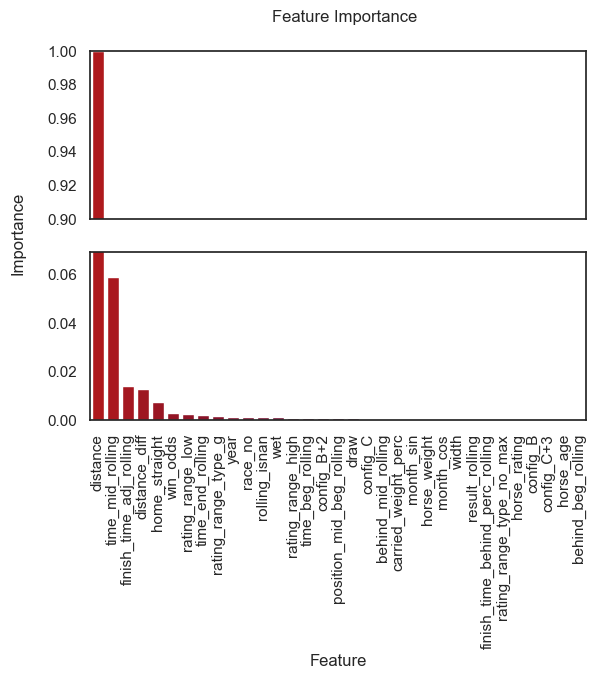

In [61]:
weights_df, unused_terms = get_feature_imp(runs_X, regr, ['rfr', 'etr', 'xgbr'],
                                           [rfr_feat_importances, etr_feat_importances, xgbr_feat_importances],
                                           0.001, 0.001, True, True)
weights_df

### Unused Features

There are no more terms recommended to be discarded (this is based on the passed thresholds, which is admittedly a bit more of an art than a science).

In [62]:
unused_terms

[]

### Correlation Matrix

Inspect the correlation matrix for the different feature importance scores by model. They should all be pretty strongly correlated.

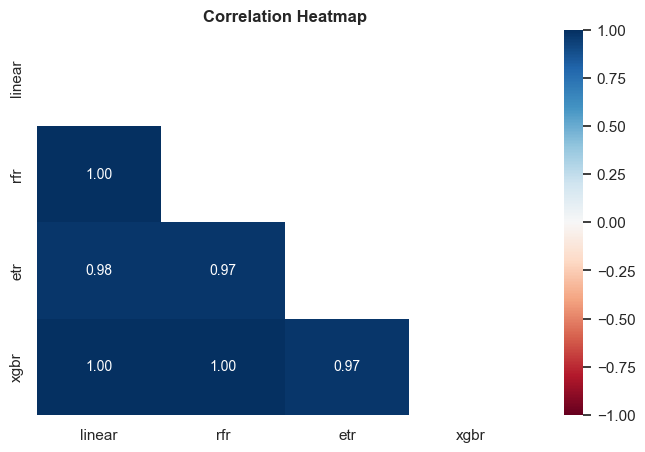

In [63]:
weights_df = weights_df.rename(columns={'linear_weights_stds':'linear', 'rfr_weights_stds':'rfr', 'etr_weights_stds':'etr',
                                        'xgbr_weights_stds':'xgbr'})

sns.set(style = "white")
plt.figure(figsize=(8, 5))
corr_matrix = weights_df.iloc[:, 0:-1].select_dtypes(include='number').corr()
# corr_matrix = weights_df.fillna(0).corr()
mask = np.triu(np.ones_like(corr_matrix))
sns.heatmap(corr_matrix, cmap="RdBu", vmax=1, vmin = -1, annot = True, annot_kws={"size": 10}, fmt='.2f', mask=mask)
plt.title("Correlation Heatmap", fontweight='bold')
plt.show()

For fun I also tried running a k-nearest neighbor model, but usurprisingly this didn't perform very well even after tuning for the optimal k value. We won't include this in our ensemble.

In [64]:
knnr = KNeighborsRegressor(n_neighbors=7).fit(X_train, y_train)

print("Train:", round(knnr.score(X_train, y_train), 4))
print("Train MSE:", round(sum(((knnr.predict(X_train) - y_train)**2).to_list()) / len(y_train), 4))
print("Train MAPE:", round(sum(abs((knnr.predict(X_train) - y_train) / y_train).to_list()) / len(y_train), 4))
print('--------------------')
print("Val:", round(knnr.score(X_val, y_val), 4))
print("Val MSE:", round(sum(((knnr.predict(X_val) - y_val)**2).to_list()) / len(y_val), 4))
print("Val MAPE:", round(sum(abs((knnr.predict(X_val) - y_val) / y_val).to_list()) / len(y_val), 4))

Train: 0.8707
Train MSE: 44.2694
Train MAPE: 0.0582
--------------------
Val: 0.8246
Val MSE: 60.3557
Val MAPE: 0.0685


## GridSearch with K=3 Folds Cross Validation

Now we'll begin the hyperparameter tuning using a k folds cross validation grid search.

Split the data into training and testing data using the same random state as earlier to ensure a fair comparison with the baseline.

In [65]:
x_train, x_test, y_train, y_test = train_test_split(runs_X, runs_y, test_size = 0.80, random_state = 42)

Below is a function to tune hyperparameters. It takes the name of the regressor, the training inputs, and the training values.

In [66]:
def ParameterSearch(regressor, x_train, y_train):
    """
    This is a k=5 cross fold validation function to find optimal parameters for
    different regressors.

    Parameters:
    ------------
    regressor: (string)
      type or regressor to be run ("enr", "rfr", "etr", "gbr", "xgbr", "knnr", "ablr")
    scaler_bool: bool
      True to apply standard scaler to the input data first
    degree: int
      degree to which the X_train input will be converted prior to running the
      regressor
    interaction_only: bool
      if the X_train input degree will only add interaction terms
    X_train: DataFrame
      training inputs
    y_train: DataFrame
      training outputs

    Returns:
    ------------
    None
    """

    # normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(x_train)
    X_train = np.nan_to_num(X_train)

    # all of the regressor options to be run
    lr = Ridge(random_state=42)
    rfr = RandomForestRegressor(random_state=42, n_jobs = -1)
    etr = ExtraTreesRegressor(random_state=42, n_jobs = -1)
    mlpr = MLPRegressor(random_state=42, max_iter=10000)
    xgbr = XGBoost.XGBRegressor(random_state=42, n_jobs=-1)
    knnr = KNeighborsRegressor(n_jobs=-1)

    # parameter values to be tried
    lr_grid = {
        'lr__alpha': [0.1, 0.25, 0.5, 1, 2, 3, 5, 10],
    }
    rfr_grid = {
        'rfr__max_depth': [4, 6, 8, 10],
        'rfr__max_features': ['sqrt', None],
        'rfr__min_samples_leaf': [4, 8, 16, 32],
        'rfr__n_estimators': [50, 100, 200],
        'rfr__bootstrap': [True],
        'rfr__max_samples': [0.25, 0.5, 1]
    }
    etr_grid = {
        'etr__max_depth': [4, 6, 8, 10],
        'etr__max_features': ['sqrt', None],
        'etr__min_samples_leaf': [4, 8, 16, 32],
        'etr__n_estimators': [50, 100, 200],
        'etr__bootstrap': [True],
        'etr__max_samples': [0.25, 0.5, 1]
    }
    mlpr_grid = {
        'mlpr__hidden_layer_sizes': [(i, j) for i in [5, 10, 15, 20, 25, 30] for j in range(3, 6)],
        'mlpr__alpha': [i/2 for i in list(range(7))],
    }
    xgbr_grid = {
        'xgbr__max_depth': [5, 10, 20],
        'xgbr__n_estimators': [100, 200, 300],
        'xgbr__gamma': [1],
        'xgbr__eta': [0.05, 0.1],
        'xgbr__subsample': [0.25],
        'xgbr__min_child_weight': [0.25, 0.5],
        'xgbr__reg_lambda': [0.5, 1],
        'xgbr__alpha': [0.5, 1]
    }
    knnr_grid = {
        'knnr__n_neighbors': list(range(1, 51, 1))
    }


    # set up the grid and pipe for the chosen regressor
    if regressor=='lr':
        grid = lr_grid
        pipe = Pipeline(steps=[('lr', lr)])
    if regressor=='rfr':
        grid = rfr_grid
        pipe = Pipeline(steps=[('rfr', rfr)])
    elif regressor=='etr':
        grid = etr_grid
        pipe = Pipeline(steps=[('etr', etr)])
    elif regressor=='mlpr':
        grid = mlpr_grid
        pipe = Pipeline(steps=[('mlpr', mlpr)])
    elif regressor=='xgbr':
        grid = xgbr_grid
        pipe = Pipeline(steps=[('xgbr', xgbr)])
    elif regressor=='knnr':
        grid = knnr_grid
        pipe = Pipeline(steps=[('knnr', knnr)])


    # create the GridSearchCV object, and fit the passed input to it
    gs = GridSearchCV(pipe, grid, n_jobs=-1, cv=3, verbose=1)
    gs.fit(X_train, y_train)

    # print out the best score on the cross validation holdout data and the best parameters
    print("Best score:", gs.best_score_)
    print()
    print(gs.best_params_)

In [67]:
ParameterSearch('lr', x_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best score: 0.9959865525909511

{'lr__alpha': 0.25}


In [ ]:
ParameterSearch('rfr', x_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


In [ ]:
ParameterSearch('etr', x_train, y_train)

In [ ]:
ParameterSearch('mlpr', x_train, y_train)

In [ ]:
ParameterSearch('xgbr', x_train, y_train)

In [ ]:
ParameterSearch('knnr', x_train, y_train)

## Ensemble

Once all the hyperparameters have been tuned and the features have been iteratively chosen, proceed with the ensemble to get the final predictions.

In [ ]:
def EnsemblePredictor(x_train, y_train, x_test, y_test=None):
    """
    An ensemble regressor estimation function.

    Parameters:
    ------------
    X_train: DataFrame
      training inputs
    y_train: DataFrame
      training outputs
    X_test: DataFrame
      testing inputs
    y_test: DataFrame
      testing outputs

    Returns:
    ------------
    None (if y_test != None)

    """

    # normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(x_train)
    X_train = np.nan_to_num(X_train)
    X_test = scaler.transform(x_test)
    X_test = np.nan_to_num(X_test)



    # estimators to be used in the ensemble
    estimators = [
        ('1', Ridge(alpha=0.25, random_state=42),),
        ('2', RandomForestRegressor(bootstrap=True, max_depth=10, max_features=None, max_samples=0.5, min_samples_leaf=4,
                                    n_estimators=200, random_state=42),),
        ('3', ExtraTreesRegressor(bootstrap=True, max_depth=10, max_features=None, max_samples=0.5, min_samples_leaf=4,
                                  n_estimators=200, random_state=42),),
        ('4', MLPRegressor(alpha=3, hidden_layer_sizes=(25, 3), random_state=42, max_iter=10000),),
        ('5', XGBoost.XGBRegressor(alpha=0.5, eta=0.05, gamma=1, max_depth=5, min_child_weight=0.25, n_estimators=200,
                                   reg_lambda=1, subsample=0.25, random_state=42),),
    ]

    # create regressors stack
    stack_reg = StackingRegressor(
        estimators=estimators
    )

    # fit the training data to the stack
    stack_reg.fit(X_train, np.ravel(y_train))

    # get train and test predictions
    y_train_pred = stack_reg.predict(X_train)
    y_test_pred = stack_reg.predict(X_test)

    # print training MSE
    print("Train MSE:", round(mean_squared_error(y_train_pred, y_train), 4))
    print("Train MAPE:", round(sum(abs((y_train_pred - y_train) / y_train).to_list()) / len(y_train), 4))

    # check if test outputs were give
    if y_test is not None:
        # if yes, print testing MSE
        print('--------------------')
        print("Test MSE:", round(mean_squared_error(y_test_pred, y_test), 4))
        print("Test MAPE:", round(sum(abs((y_test_pred - y_test) / y_test).to_list()) / len(y_test), 4))
    else:
        # if no, return the test predictions
        return y_test_pred

In [ ]:
EnsemblePredictor(x_train, y_train, x_test, y_test)

These results are pretty good. The MSE fell from the baseline's 1.4924 to 0.9605 and the MAPE went from 0.0102 to 0.0077.

# Classification

On to classification! This will require additional wrangling that picks up with the previous 'runs_full_df'. We will need to convert the dataframe from rows with each horse to a single row for each race, comprised of columns with data on each horse. We'll also try some feature engineering to get each of these horse column values in terms of how it compares to all the other horses in the race.

Another challenge will be addressing class imbalance. If some races don't have all 13 horse positions filled (there might be fewer horses competing) then the models might be less likely to predict features associated with these horses as indicative of predicting the winner.

## Wrangling

This function takes a dataframe and string feature name as input, returning a new dataframe with this feature's column transformed into a standard scaled version of its values compared to all respective values of other horses in the same row.

In [62]:
def get_comp_stats(df, feature):
    my_df = df.copy()

    mean_dict = my_df.groupby('race_id')[feature].mean().to_dict()
    std_dict = my_df.groupby('race_id')[feature].std().to_dict()

    my_df[feature+'_stds'] = my_df.apply(lambda row: row[feature] if np.isnan(row[feature]) else \
        0 if row[feature] - mean_dict[row['race_id']] == 0 else \
            (row[feature] - mean_dict[row['race_id']]) / std_dict[row['race_id']], axis=1)

    my_df = my_df.drop(columns=[feature])
    return my_df

Make a few lists of features. Solo features represent features tha will either be included in the model as inputs, outputs, or indices. Compare features on the other had, will be shown in the row instance for each horse to give more insight into which should be predicted as the winner.

As with the regression models, this is the starting point for an iterative process by which a lot of features are tried, and then slowly whittled down.

### Feature Selection

In [63]:
solo_features = ['race_id',
                 'horse_no',
                 'win_combination1',
                 'win_odds',
                 ]

compare_features = [
                    'horse_age', # don't remove this here, as it's necessary for graphs below
                    'finish_time_adj_rolling',
                    'finish_time_behind_perc_rolling',
                    'result_rolling',

                    # 'horse_rating',
                    # 'horse_weight',
                    # 'carried_weight_perc',
                    # 'distance_diff',
                    # 'time_beg_rolling',
                    # 'time_mid_rolling',
                    # 'time_end_rolling',
                    # 'behind_beg_rolling',
                    # 'behind_mid_rolling',

                    # 'rolling_isnan',
                    # 'position_mid_beg_rolling',
                    ]

The function below takes a dataframe, solo features list, and compare features list as inputs. It then hadles the rows to columns rearranging and standardization.

In [64]:
# function to combine rows of each horses data in a race into one row, with suffixes for each horse number
def prepare_cls_df(df, solo_features, compare_features):

    # the initial features (all passed features)
    initial_features = solo_features + compare_features

    # make a new compare features list with included suffixes to denote that these are standardized
    compare_features_stds = [i+'_stds' for i in compare_features]

    # these all the features that we won't be using as inputs into the model
    # they are used for indexing, performing a groupby operation below, and
    # finally, storing the gold labels
    remove_columns = ['race_id', 'horse_no', 'win_combination1']

    # make a new column resembline the initial features, but with the new suffix values
    new_columns = compare_features_stds.copy()
    new_columns = new_columns + solo_features

    # remove each feature in the remove columns list from the new columns list
    for i in remove_columns:
        new_columns.remove(i)

    # slice the dataframe to only include the initial features
    df = df[initial_features]

    # get the standardized feature values for each race
    for feature in compare_features:
        df = get_comp_stats(df, feature)

    # shift the id's down by 1 for convenience in the baseline calculations later
    # do the same for the gold labels
    df['win_combination1'] = df['win_combination1'] - 1
    df['horse_no'] = df['horse_no'] - 1

    # for each column in the columns we are trying to include in the new race row
    for col in new_columns:
        # for each horse number
        for num in set(df['horse_no']):
            # add columns for each feature + horse number pairing
            # there will be nan values for all rows other than the row also corresponding to this horse number
            df[col+'_'+str(num)] = df.apply(lambda row: row[col] if row['horse_no'] == num else np.nan, axis=1)

    # remove the 'horse_no' column and collapse the rows corresponding to each 'race_id'
    df = df.groupby('race_id').aggregate('max')


    # the model rejected this feature
    # # check if this horse number is running in the race
    # for num in [_ for _ in range(0, 14)]:
    #     # make a binary feature indicator set to True if there isn't a horse racing in this position
    #     df['horse_isnan_'+str(num)] = df.apply(lambda row: True if np.isnan(row['horse_age_stds_'+str(num)]) else False, axis=1)

    # drop the horse number column as it is no longer needed
    df = df.drop(columns=new_columns+['horse_no'])

    return df

Apply the above function to the full runs dataframe.

In [65]:
win_class_df = prepare_cls_df(runs_full_df, solo_features, compare_features)

Inspect the results.

In [66]:
win_class_df.head()

,win_combination1,horse_age_stds_0,horse_age_stds_1,horse_age_stds_2,horse_age_stds_3,horse_age_stds_4,horse_age_stds_5,horse_age_stds_6,horse_age_stds_7,horse_age_stds_8,...,win_odds_4,win_odds_5,win_odds_6,win_odds_7,win_odds_8,win_odds_9,win_odds_10,win_odds_11,win_odds_12,win_odds_13
race_id,,,,,,,,,,,,,,,,,,,,,
0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,50.0,7.0,99.0,12.0,38.0,39.0,8.6,23.0,5.4,11.0
1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.3,28.0,13.0,43.0,14.0,10.0,50.0,21.0,13.0,47.0
2,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.4,65.0,99.0,6.7,7.9,16.0,7.0,45.0,22.0,99.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.2,36.0,15.0,2.9,15.0,5.1,74.0,68.0,NaN,NaN
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33.0,43.0,12.0,13.0,6.1,11.0,19.0,31.0,99.0,25.0


In [67]:
win_class_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6348 entries, 0 to 6348
Data columns (total 71 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   win_combination1                         6348 non-null   int64  
 1   horse_age_stds_0                         6278 non-null   float64
 2   horse_age_stds_1                         6286 non-null   float64
 3   horse_age_stds_2                         6267 non-null   float64
 4   horse_age_stds_3                         6277 non-null   float64
 5   horse_age_stds_4                         6259 non-null   float64
 6   horse_age_stds_5                         6273 non-null   float64
 7   horse_age_stds_6                         6262 non-null   float64
 8   horse_age_stds_7                         6218 non-null   float64
 9   horse_age_stds_8                         6184 non-null   float64
 10  horse_age_stds_9                         6094 non-nul

### Dealing with Unbalanced Data

Below, we need to check the distribution of the horse positions and winners. The latter will tell us if we have unbalanced classes, which could be problematic for our models, biasing their predictions towards the majority classes.

/var/folders/9y/flvy6tfd14v8rmvfr2c0fry40000gn/T/ipykernel_58461/585664720.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = counts_df, x='race_position', y='counts', palette="blend:#c70004,#080072")


Text(0.5, 1.0, 'Horse Position Counts')

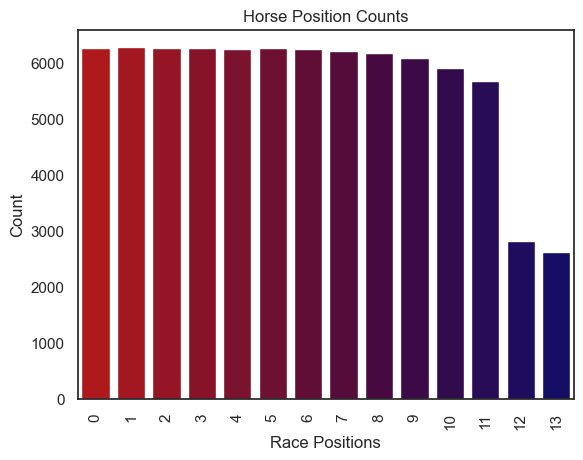

In [68]:
position_counts = win_class_df[['horse_age_stds_0', 'horse_age_stds_1', 'horse_age_stds_2', 'horse_age_stds_3', 'horse_age_stds_4',
                                'horse_age_stds_5', 'horse_age_stds_6', 'horse_age_stds_7', 'horse_age_stds_8', 'horse_age_stds_9',
                                'horse_age_stds_10', 'horse_age_stds_11', 'horse_age_stds_12', 'horse_age_stds_13']].count()

counts_df = pd.DataFrame(position_counts, columns=['counts'])
counts_df['race_position'] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

sns.barplot(data = counts_df, x='race_position', y='counts', palette="blend:#c70004,#080072")
plt.xticks(rotation=90)

plt.xlabel('Race Positions')
plt.ylabel('Count')
plt.title('Horse Position Counts')

/var/folders/9y/flvy6tfd14v8rmvfr2c0fry40000gn/T/ipykernel_58461/2243119358.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = win_counts_df, x='race_position', y='counts', palette="blend:#c70004,#080072")


Text(0.5, 1.0, 'Win Position Counts')

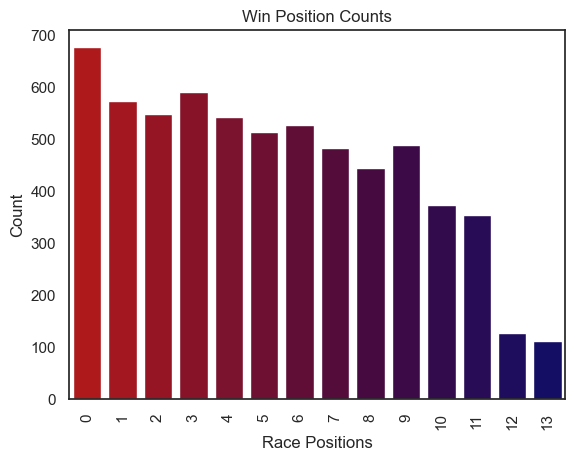

In [69]:
win_counts = win_class_df.reset_index()[['win_combination1', 'race_id']].groupby('win_combination1').count()['race_id'].to_list()

win_counts_df = pd.DataFrame(win_counts, columns=['counts'])
win_counts_df['race_position'] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

sns.barplot(data = win_counts_df, x='race_position', y='counts', palette="blend:#c70004,#080072")
plt.xticks(rotation=90)

plt.xlabel('Race Positions')
plt.ylabel('Count')
plt.title('Win Position Counts')

As we can see here, the data is unbalanced with the 1st position winning much more often and the 12th and 13th positions, which don't always have horses racing in them.

Notice that there's a race missing even though there's data on horses that competed in this race. This will need to be adjusted for in the cell a few spots below.

In [70]:
set(races_df['race_id']) - set(win_class_df.index.to_list())

{6108}

Another problem is that there are races for which the winning horse doesn't appear in 'runs_df'. These need to be dropped. We will do this a bit later. Below is an example of this problem. race id #50 says that the horse in position 3 was the winner even though we don't have data on this horse for this specific race.

In [71]:
races_df[races_df['race_id'] == 50][['race_id', 'win_combination1']]

,race_id,win_combination1
50,50,3


In [72]:
runs_df[runs_df['race_id'] == 50][['race_id', 'horse_no']]

,race_id,horse_no
612,50,1
613,50,2
614,50,4
615,50,5
616,50,6
617,50,7
618,50,8
619,50,9
620,50,10
621,50,11


Below is a function to permute the horse positions and modify a globally defined conv_lst to contain dictionaries mapping from the original horse numbers to the new values for each race – we need these dictionaries to also convert the winning horse number 'win_combination1'. Ultimately, by shuffling the positions we can fix the class imbalance. This shouldn't affect the model negative either as these numbers don't have a meaningful representation – it's actually the 'draw' feature that states the lane being run in.

In [73]:
def my_permute(x):
    # print(x)
    lst = [i for i in range(1, 15)]
    length = len(x)
    random.shuffle(lst)
    transformed = x.apply(lambda x: lst[x-1])
    conv_dict = dict(zip(x.to_list(), transformed.to_list()))
    conv_lst.append(conv_dict)
    # gold_label = x.apply(lambda x: lst[0:length][x])
    # return lst[0:length]
    return transformed.tolist()

Apply the above function and use the 'conv_lst' to transform the winning predictions as well.

In [74]:
random.seed(42)
temp = runs_full_df.copy()
conv_lst = []
temp['horse_no'] = temp[['race_id', 'horse_no']].groupby('race_id').transform(my_permute)
# adjust for the missing race_id 6108
temp['race_id'] = temp['race_id'].apply(lambda x: x-1 if x > 6108 else x)
temp['win_combination1'] = temp.apply(lambda row: conv_lst[row['race_id']].get(row['win_combination1']), axis=1)
temp[['race_id', 'horse_no', 'win_combination1']]

,race_id,horse_no,win_combination1
0,0,9,3.0
1,0,13,3.0
2,0,8,3.0
3,0,7,3.0
4,0,14,3.0
...,...,...,...
79442,6347,14,8.0
79443,6347,7,8.0
79444,6347,1,8.0
79445,6347,9,8.0


Now we can perform the class preparation transformation on this newly balanced data.

In [75]:
win_class_df = prepare_cls_df(temp, solo_features, compare_features)

# also delete the rows (races) where the winning horse's data isn't included.
win_class_df = win_class_df[win_class_df['win_combination1'].notna()]

Inspect the results. Things should look much more balanced now.

/var/folders/9y/flvy6tfd14v8rmvfr2c0fry40000gn/T/ipykernel_58461/585664720.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = counts_df, x='race_position', y='counts', palette="blend:#c70004,#080072")


Text(0.5, 1.0, 'Horse Position Counts')

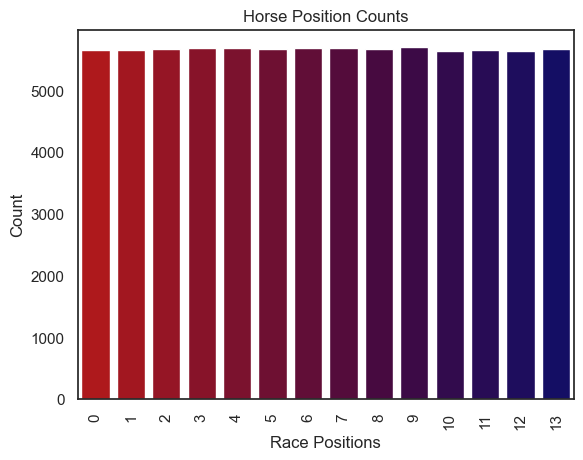

In [76]:
position_counts = win_class_df[['horse_age_stds_0', 'horse_age_stds_1', 'horse_age_stds_2', 'horse_age_stds_3', 'horse_age_stds_4',
                                'horse_age_stds_5', 'horse_age_stds_6', 'horse_age_stds_7', 'horse_age_stds_8', 'horse_age_stds_9',
                                'horse_age_stds_10', 'horse_age_stds_11', 'horse_age_stds_12', 'horse_age_stds_13']].count()

counts_df = pd.DataFrame(position_counts, columns=['counts'])
counts_df['race_position'] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

sns.barplot(data = counts_df, x='race_position', y='counts', palette="blend:#c70004,#080072")
plt.xticks(rotation=90)

plt.xlabel('Race Positions')
plt.ylabel('Count')
plt.title('Horse Position Counts')

The horse position distribution looks much better.

/var/folders/9y/flvy6tfd14v8rmvfr2c0fry40000gn/T/ipykernel_58461/2243119358.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = win_counts_df, x='race_position', y='counts', palette="blend:#c70004,#080072")


Text(0.5, 1.0, 'Win Position Counts')

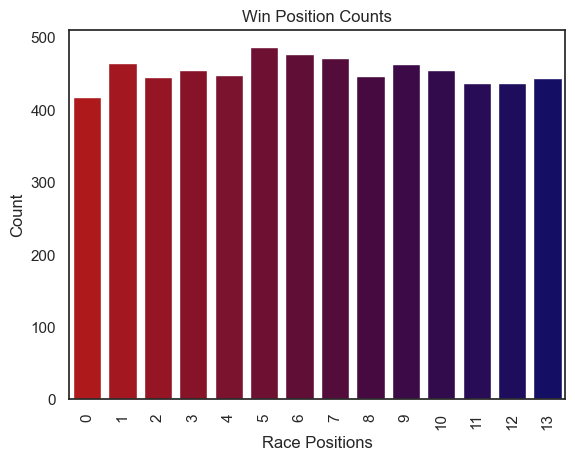

In [77]:
win_counts = win_class_df.reset_index()[['win_combination1', 'race_id']].groupby('win_combination1').count()['race_id'].to_list()

win_counts_df = pd.DataFrame(win_counts, columns=['counts'])
win_counts_df['race_position'] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

sns.barplot(data = win_counts_df, x='race_position', y='counts', palette="blend:#c70004,#080072")
plt.xticks(rotation=90)

plt.xlabel('Race Positions')
plt.ylabel('Count')
plt.title('Win Position Counts')

Similarly, the class imbalance is no longer an issue.

This cell below is optional based on the model. If the model prefers not to use horse ages, then run the cell. It was necessary to keep these columns until this point to get the graphs above. Every horse has a listed age, so they could be used to check if horses ran in this position during races.

In [ ]:
win_class_df = win_class_df.drop(columns=['horse_age_stds_0', 'horse_age_stds_1', 'horse_age_stds_2', 'horse_age_stds_3', 'horse_age_stds_4',
                           'horse_age_stds_5', 'horse_age_stds_6', 'horse_age_stds_7', 'horse_age_stds_8', 'horse_age_stds_9',
                           'horse_age_stds_10', 'horse_age_stds_11', 'horse_age_stds_12', 'horse_age_stds_13'])

## Baseline

For a baseline, get the winner prediction based on the horse with the best (lowest) win odds. If there are multiple horses with the same odds, this will take the one with the lowest horse number. However, since these were randomized, this is equivalent to randomly picking among the best odds horses.

In [86]:
temp = win_class_df[['win_odds_0', 'win_odds_1', 'win_odds_2', 'win_odds_3', 'win_odds_4', 'win_odds_5', 'win_odds_6',
                      'win_odds_7', 'win_odds_8', 'win_odds_9', 'win_odds_10', 'win_odds_11', 'win_odds_12', 'win_odds_13']]

temp.idxmin(axis=1)

race_id
0        win_odds_7
1       win_odds_10
2       win_odds_11
3        win_odds_1
4        win_odds_0
           ...     
6343    win_odds_11
6344     win_odds_5
6345     win_odds_5
6346     win_odds_3
6347     win_odds_2
Length: 6342, dtype: object

These are the true gold labels. You can already see some correct predictions.

In [87]:
win_class_df['win_combination1']

race_id
0        2.0
1       10.0
2        9.0
3        7.0
4        0.0
        ... 
6343     0.0
6344    13.0
6345     5.0
6346     3.0
6347     7.0
Name: win_combination1, Length: 6342, dtype: float64

Below, we focus on getting the cross entropy loss, which requires a softmax.

In [88]:
# standardize the features of all the horses in each race (on a feature-by-feature basis)
scaler = StandardScaler()
# flip the sign since small odds actually signify a greater chance of winning
scaled_temp_df = scaler.fit_transform(temp.T).T * -1

# convert the scaled values into a dataframe, apply the exponential function
scaled_temp_df = pd.DataFrame(scaled_temp_df, index=[temp.index], columns=[temp.columns.to_list()])
scaled_temp_df = np.exp(scaled_temp_df)
# sum the results of each row into a new total column
scaled_temp_df['total'] = scaled_temp_df.sum(axis=1, numeric_only=True)

# for each horse number, change the win_odds column to be itself as a fraction of the total in its row
for i in range(0, 14):
    scaled_temp_df['win_odds_'+str(i)] = scaled_temp_df.apply(lambda row: row['win_odds_'+str(i)] / row['total'], axis=1)

scaled_temp_df.head()

,win_odds_0,win_odds_1,win_odds_2,win_odds_3,win_odds_4,win_odds_5,win_odds_6,win_odds_7,win_odds_8,win_odds_9,win_odds_10,win_odds_11,win_odds_12,win_odds_13,total
race_id,,,,,,,,,,,,,,,
0,0.058638,0.118429,0.090987,0.030949,0.104221,0.002818,0.030949,0.127766,0.099741,0.032210,0.094694,0.111098,0.077553,0.019946,19.071690
1,0.051335,0.088129,0.007238,0.132176,0.088129,0.082373,0.107928,0.082373,0.031992,0.008864,0.181569,0.094289,0.011614,0.031992,20.275905
2,0.114048,0.010516,0.016843,0.124985,0.092266,0.078861,0.110233,0.117685,0.025599,0.116765,0.010516,0.127963,0.043202,0.010516,20.487902
3,0.090057,0.149792,0.026603,0.090057,0.090057,0.007535,0.119867,0.135984,0.106553,0.009697,NaN,0.136557,0.037241,NaN,16.872783
4,0.126996,0.002307,0.085561,0.104679,0.066497,0.114334,0.040165,0.093061,0.045560,0.089232,0.118740,0.024260,0.036928,0.051680,18.615028


Get the odds-predicted winner. Get the gold labels. Get the percentage of correct predictions.

In [89]:
odds_pred = scaled_temp_df[['win_odds_0', 'win_odds_1', 'win_odds_2', 'win_odds_3', 'win_odds_4', 'win_odds_5', 'win_odds_6',
                            'win_odds_7', 'win_odds_8', 'win_odds_9', 'win_odds_10', 'win_odds_11', 'win_odds_12', 'win_odds_13']].idxmax(axis = 1)

odds_pred = odds_pred.apply(lambda x: x[0].split('_')[-1])
pred = [int(i) for i in odds_pred.to_list()][0:6107]
y_labels = win_class_df['win_combination1']
y_labels = y_labels.to_list()

correct = 0
for i in range(len(pred)):
    if pred[i] == y_labels[i]:
        correct += 1

print("Baseline Percentage Correct:", round(correct / len(pred), 4))

Baseline Percentage Correct: 0.2992


To get the cross entropy loss, there cannot be null values, so these will be replaced with the minimal value in the row. This assumes that horses with null odds have the same chance of winning the race as the horse with the lowest odds. Some of these null values are horses whose odds aren't included in the data. Other null values represent horse numbers not represented in the race. By making the worst odds assumption, this will likely increase the baseline cross entropy loss. This is okay, though, as it's just a baseline, and the accuracy will not be impacted.

In [90]:
def replace_nan_with_min(row):
    min_val = np.nanmin(row)
    return [min_val if np.isnan(val) else val for val in row]

# Apply the function to each row, expanding the results
scaled_temp_df = scaled_temp_df.apply(replace_nan_with_min, axis=1, result_type='expand')

Now get the baseline results on data split into train-test values. Using a passed random state, we can compare our test results on the same data as the baseline.

In [91]:
# perform an 80-20 split
x_train, x_test, y_train, y_test = train_test_split(scaled_temp_df, y_labels, test_size = 0.80, random_state = 42)

In [92]:
pred = [_ for _ in x_test.loc[:, 0: 13].idxmax(axis = 1)]

correct = 0
for i in range(len(pred)):
    if int(pred[i]) == y_test[i]:
        correct += 1

print("Baseline Percentage Correct:", round(correct / len(pred), 4))

Baseline Percentage Correct: 0.3006


In [93]:
pred_array = np.array(x_test)
predictions = []
for index, y in enumerate(y_test):
    predictions.append(pred_array[index,int(y)])

print("Baseline Cross Entropy Loss:", round(-np.log(predictions).sum(), 2))

Baseline Cross Entropy Loss: 11069.78


These scores are pretty good, and intuitively, we'd expect that the win odds will be the most predictive feature. It will be hard to improve upon this as any low-hanging fruit insights from basic data are likely already baked into these Vegas lines (remember a lot of money is at stake when they set these).

## Individual Models

Make a function to get the cross entropy loss.

In [173]:
def get_cel(pred, y_val):
    pred_array = np.array(pred)
    predictions = []
    for index, y in enumerate(y_val):
        predictions.append(pred_array[index,int(y)])

    return round(-np.log(predictions).sum(), 2)

Get the inputs and outputs, split the data in the same manner as before, and standard scale the features.

In [174]:
races_y = win_class_df['win_combination1']
races_X = win_class_df.drop(columns='win_combination1')

# 60/20/20 train-val-test split
x_train_val, x_test, y_train_val, y_test = train_test_split(races_X, races_y, test_size = 0.80, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = 0.75, random_state = 42)

In [175]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(x_train_val)
X_train_val = np.nan_to_num(X_train_val)

X_test = scaler.transform(x_test)
X_test = np.nan_to_num(X_test)

y_train_val = y_train_val.astype(int)
y_test = y_test.astype(int)

In [176]:
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_train = np.nan_to_num(X_train)

X_val = scaler.transform(x_val)
X_val = np.nan_to_num(X_val)

y_train = y_train.astype(int)
y_val = y_val.astype(int)

### Logistic Regression

#### Validation

In [177]:
lc = LogisticRegression(solver='saga', penalty='elasticnet', C=0.05, l1_ratio=0.75, max_iter=10000, random_state=42).fit(X_train, y_train)

train_pred = lc.predict_proba(X_train)
val_pred = lc.predict_proba(X_val)

print("Train Mean Accuracy:", round(lc.score(X_train, y_train), 4))
print("Train Cross Entropy Loss:", get_cel(train_pred, y_train))
print('--------------------')
print("Val Mean Accuracy:", round(lc.score(X_val, y_val), 4))
print("Val Cross Entropy Loss:", get_cel(val_pred, y_val))

Train Mean Accuracy: 0.164
Train Cross Entropy Loss: 816.27
--------------------
Val Mean Accuracy: 0.1115
Val Cross Entropy Loss: 2482.53


#### Test

In [142]:
lc = LogisticRegression(solver='saga', penalty='elasticnet', C=0.05, l1_ratio=0.75, max_iter=10000, random_state=42).fit(X_train_val, y_train_val)

train_val_pred = lc.predict_proba(X_train_val)
test_pred = lc.predict_proba(X_test)

print("Train Mean Accuracy:", round(lc.score(X_train_val, y_train_val), 4))
print("Train Cross Entropy Loss:", get_cel(train_val_pred, y_train_val))
print('--------------------')
print("Test Mean Accuracy:", round(lc.score(X_test, y_test), 4))
print("Test Cross Entropy Loss:", get_cel(test_pred, y_test))

Train Mean Accuracy: 0.265
Train Cross Entropy Loss: 2848.1
--------------------
Test Mean Accuracy: 0.2199
Test Cross Entropy Loss: 11655.03


### Multi-layer Perceptron Classifier

#### Validation

In [178]:
mlpc = MLPClassifier(alpha=2.5, hidden_layer_sizes=(20, 30), random_state=42, max_iter=10000).fit(X_train, y_train)

train_pred = mlpc.predict_proba(X_train)
val_pred = mlpc.predict_proba(X_val)

print("Train Mean Accuracy:", round(mlpc.score(X_train, y_train), 4))
print("Train Cross Entropy Loss:", get_cel(train_pred, y_train))
print('--------------------')
print("Val Mean Accuracy:", round(mlpc.score(X_val, y_val), 4))
print("Val Cross Entropy Loss:", get_cel(val_pred, y_val))

Train Mean Accuracy: 1.0
Train Cross Entropy Loss: 95.34
--------------------
Val Mean Accuracy: 0.1377
Val Cross Entropy Loss: 3760.17


#### Test

In [143]:
mlpc = MLPClassifier(alpha=2.5, hidden_layer_sizes=(20, 30), random_state=42, max_iter=10000).fit(X_train_val, y_train_val)

train_val_pred = mlpc.predict_proba(X_train_val)
test_pred = mlpc.predict_proba(X_test)

print("Train Mean Accuracy:", round(mlpc.score(X_train_val, y_train_val), 4))
print("Train Cross Entropy Loss:", get_cel(train_val_pred, y_train_val))
print('--------------------')
print("Test Mean Accuracy:", round(mlpc.score(X_test, y_test), 4))
print("Test Cross Entropy Loss:", get_cel(test_pred, y_test))

Train Mean Accuracy: 0.474
Train Cross Entropy Loss: 2100.83
--------------------
Test Mean Accuracy: 0.1606
Test Cross Entropy Loss: 13286.66


### Random Forest Classifier

#### Validation

In [179]:
rfc = RandomForestClassifier(bootstrap=True, max_depth=8, max_features=None, max_samples=0.25, min_samples_leaf=4,
                             n_estimators=50, random_state=42).fit(X_train, y_train)

importances = rfc.feature_importances_
rfc_feat_importances = pd.DataFrame(importances, index=races_X.columns, columns=['importance'])

train_pred = rfc.predict_proba(X_train)
val_pred = rfc.predict_proba(X_val)

print("Train Mean Accuracy:", round(rfc.score(X_train, y_train), 4))
print("Train Cross Entropy Loss:", get_cel(train_pred, y_train))
print('--------------------')
print("Val Mean Accuracy:", round(rfc.score(X_val, y_val), 4))
print("Val Cross Entropy Loss:", get_cel(val_pred, y_val))

Train Mean Accuracy: 0.7129
Train Cross Entropy Loss: 548.44
--------------------
Val Mean Accuracy: 0.1882
Val Cross Entropy Loss: 2335.82


#### Test

In [147]:
rfc = RandomForestClassifier(bootstrap=True, max_depth=8, max_features=None, max_samples=0.25, min_samples_leaf=4,
                             n_estimators=50, random_state=42).fit(X_train_val, y_train_val)

train_val_pred = rfc.predict_proba(X_train_val)
test_pred = rfc.predict_proba(X_test)

print("Train Mean Accuracy:", round(rfc.score(X_train_val, y_train_val), 4))
print("Train Cross Entropy Loss:", get_cel(train_val_pred, y_train_val))
print('--------------------')
print("Test Mean Accuracy:", round(rfc.score(X_test, y_test), 4))
print("Test Cross Entropy Loss:", get_cel(test_pred, y_test))

Train Mean Accuracy: 0.5032
Train Cross Entropy Loss: 2325.25
--------------------
Test Mean Accuracy: 0.2558
Test Cross Entropy Loss: 11916.64


### Extra Trees Classifier (variant of a random forest classifier)

#### Validation

In [180]:
etc = ExtraTreesClassifier(bootstrap=True, max_depth=6, max_features=None, max_samples=0.5, min_samples_leaf=4,
                           n_estimators=200, random_state=42).fit(X_train, y_train)

importances = etc.feature_importances_
etc_feat_importances = pd.DataFrame(importances, index=races_X.columns, columns=['importance'])

train_pred = etc.predict_proba(X_train)
val_pred = etc.predict_proba(X_val)

print("Train Mean Accuracy:", round(etc.score(X_train, y_train), 4))
print("Train Cross Entropy Loss:", get_cel(train_pred, y_train))
print('--------------------')
print("Val Mean Accuracy:", round(etc.score(X_val, y_val), 4))
print("Val Cross Entropy Loss:", get_cel(val_pred, y_val))

Train Mean Accuracy: 0.9338
Train Cross Entropy Loss: 560.5
--------------------
Val Mean Accuracy: 0.1735
Val Cross Entropy Loss: 2382.4


#### Test

In [145]:
etc = ExtraTreesClassifier(bootstrap=True, max_depth=6, max_features=None, max_samples=0.5, min_samples_leaf=4,
                           n_estimators=200, random_state=42).fit(X_train_val, y_train_val)

train_val_pred = etc.predict_proba(X_train_val)
test_pred = etc.predict_proba(X_test)

print("Train Mean Accuracy:", round(etc.score(X_train_val, y_train_val), 4))
print("Train Cross Entropy Loss:", get_cel(train_val_pred, y_train_val))
print('--------------------')
print("Test Mean Accuracy:", round(etc.score(X_test, y_test), 4))
print("Test Cross Entropy Loss:", get_cel(test_pred, y_test))

Train Mean Accuracy: 0.7405
Train Cross Entropy Loss: 2490.56
--------------------
Test Mean Accuracy: 0.2298
Test Cross Entropy Loss: 12334.81


### Extreme Gradient Boosting Classifier

#### Validation

In [181]:
xbgc = XGBoost.XGBClassifier(alpha=0.5, eta=0.05, gamma=1, max_depth=10, min_child_weight=0.25, n_estimators=100,
                             reg_lambda=0.5, subsample=0.25, random_state=42).fit(X_train, y_train)

importances = xbgc.feature_importances_
xbgc_feat_importances = pd.DataFrame(importances, index=races_X.columns, columns=['importance'])

train_pred = xbgc.predict_proba(X_train)
val_pred = xbgc.predict_proba(X_val)

print("Train Mean Accuracy:", round(xbgc.score(X_train, y_train), 4))
print("Train Cross Entropy Loss:", get_cel(train_pred, y_train))
print('--------------------')
print("Val Mean Accuracy:", round(xbgc.score(X_val, y_val), 4))
print("Val Cross Entropy Loss:", get_cel(val_pred, y_val))

Train Mean Accuracy: 0.9211
Train Cross Entropy Loss: 345.06
--------------------
Val Mean Accuracy: 0.2177
Val Cross Entropy Loss: 2243.29


#### Test

In [146]:
xbgc = XGBoost.XGBClassifier(alpha=0.5, eta=0.05, gamma=1, max_depth=10, min_child_weight=0.25, n_estimators=100,
                             reg_lambda=0.5, subsample=0.25, random_state=42).fit(X_train_val, y_train_val)

train_val_pred = xbgc.predict_proba(X_train_val)
test_pred = xbgc.predict_proba(X_test)

print("Train Mean Accuracy:", round(xbgc.score(X_train_val, y_train_val), 4))
print("Train Cross Entropy Loss:", get_cel(train_val_pred, y_train_val))
print('--------------------')
print("Test Mean Accuracy:", round(xbgc.score(X_test, y_test), 4))
print("Test Cross Entropy Loss:", get_cel(test_pred, y_test))

Train Mean Accuracy: 0.9006
Train Cross Entropy Loss: 1162.88
--------------------
Test Mean Accuracy: 0.2493
Test Cross Entropy Loss: 11438.09


## Feature Importance

/var/folders/9y/flvy6tfd14v8rmvfr2c0fry40000gn/T/ipykernel_49944/402857147.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=weights_df, x="features", y="mean_weights_importance", ax=ax1, palette="blend:#c70004,#080072")
/var/folders/9y/flvy6tfd14v8rmvfr2c0fry40000gn/T/ipykernel_49944/402857147.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=weights_df, x="features", y="mean_weights_importance", ax=ax2, palette="blend:#c70004,#080072")


,features,linear,rfc,etc,xbgc,mean_weights_importance
1,win_odds,0.318663,1.716781,1.539317,1.570924,1.000000
2,result_rolling_stds,1.498897,-0.394961,0.182466,0.009187,0.576452
3,finish_time_behind_perc_rolling_stds,-0.908780,-0.553521,-0.621162,-0.413401,0.159244
0,finish_time_adj_rolling_stds,-0.908780,-0.768299,-1.100621,-1.166710,0.000000


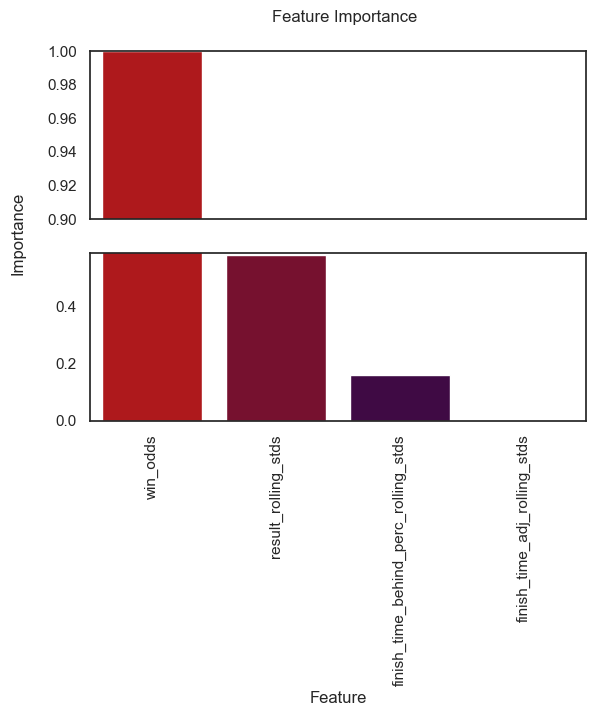

In [182]:
weights_df, unused_terms = get_feature_imp(races_X, lc, ['rfc', 'etc', 'xbgc'],
                                           [rfc_feat_importances, etc_feat_importances, xbgc_feat_importances],
                                           0.001, 0.0001, False, True)
weights_df

### Unused Features

Below are the features that were below the passed thresholds across all models. I'm choosing to keep them, however, as they work well in theory, and I don't want the model to rely solely on the win odds.

In [102]:
unused_terms

['finish_time_adj_rolling_stds', 'finish_time_behind_perc_rolling_stds']

### Correlation Matrix

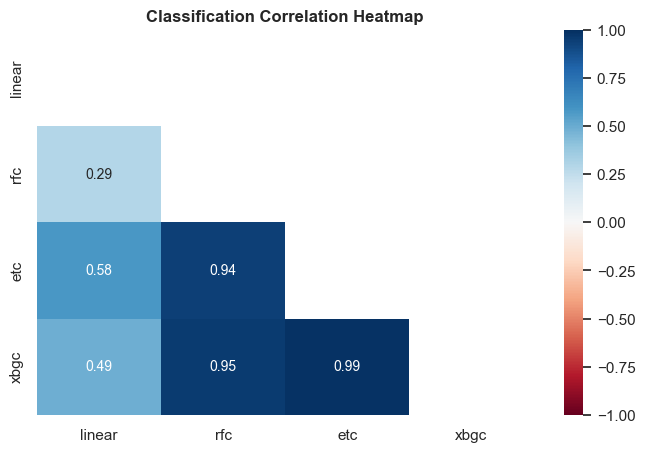

In [183]:
sns.set(style = "white")
plt.figure(figsize=(8,5))
corr_matrix = weights_df.iloc[:, 0:-1].select_dtypes(include='number').corr()
mask = np.triu(np.ones_like(corr_matrix))
sns.heatmap(corr_matrix, cmap="RdBu", vmax=1, vmin = -1, annot = True, annot_kws={"size": 10}, fmt='.2f', mask=mask)
plt.title("Classification Correlation Heatmap", fontweight='bold')
plt.show()

## GridSearch with K=3 Folds Cross Validation

In [104]:
x_train, x_test, y_train, y_test = train_test_split(races_X, races_y, test_size = 0.80, random_state = 42)

In [105]:
def ParameterSearch(regressor, x_train, y_train):
    """
    This is a k=5 cross fold validation function to find optimal parameters for
    different regressors.

    Parameters:
    ------------
    regressor: (string)
      type or regressor to be run ("rfr", "etr", "gbr", "xgb", "knnr", "ablr",
                                   "svr", "lr")
    scaler_bool: bool
      True to apply standard scaler to the input data first
    degree: int
      degree to which the X_train input will be converted prior to running the
      regressor
    interaction_only: bool
      if the X_train input degree will only add interaction terms
    X_train: DataFrame
      training inputs
    y_train: DataFrame
      training outputs

    Returns:
    ------------
    None
    """

    # normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(x_train)
    X_train = np.nan_to_num(X_train)

    # all of the regressor options to be run
    rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
    etc = ExtraTreesClassifier(random_state=42, n_jobs=-1)
    mlpc = MLPClassifier(random_state=42,  max_iter=10000)
    xgb = XGBoost.XGBClassifier(random_state=42, n_jobs=-1)
    knnc = KNeighborsClassifier()
    lc = LogisticRegression(solver='saga', penalty='elasticnet', max_iter=10000, random_state=42, n_jobs=-1)

    # parameter values to be tried
    rfc_grid = {
        'rfc__max_depth': [4, 6, 8, 10, 15, 20, 25, 30, 50],
        'rfc__max_features': ['sqrt', None],
        'rfc__min_samples_leaf': [4, 8, 16, 32],
        'rfc__n_estimators': [50, 100, 200],
        'rfc__bootstrap': [True],
        'rfc__max_samples': [0.25, 0.5, 1]
    }
    etc_grid = {
        'etc__max_depth': [4, 6, 8, 10, 15, 20, 25, 30, 50],
        'etc__max_features': ['sqrt', None],
        'etc__min_samples_leaf': [4, 8, 16, 32],
        'etc__n_estimators': [50, 100, 200],
        'etc__bootstrap': [True],
        'etc__max_samples': [0.25, 0.5, 1]
    }
    mlpc_grid = {
        'mlpc__hidden_layer_sizes': [(i, j) for i in [5, 10, 15, 20, 30, 40, 50, 75, 100, 125, 150, 200, 300] for j in range(5, 31, 5)],
        'mlpc__alpha': [i/2 for i in list(range(7))],
    }
    xgb_grid = {
        'xgb__max_depth': [5, 10, 20, 30, 50],
        'xgb__n_estimators': [100, 200, 300],
        'xgb__gamma': [1],
        'xgb__eta': [0.05, 0.1],
        'xgb__subsample': [0.25],
        'xgb__min_child_weight': [0.25, 0.5],
        'xgb__reg_lambda': [0.5, 1],
        'xgb__alpha': [0.5, 1]
    }
    lc_grid = {
        'lc__C': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10],
        'lc__l1_ratio': [0.01, 0.25, 0.5, 0.75, 0.99],
    }

    # set up the grid and pipe for the chosen regressor
    if regressor=='rfc':
        grid = rfc_grid
        pipe = Pipeline(steps=[('rfc', rfc)])
    elif regressor=='etc':
        grid = etc_grid
        pipe = Pipeline(steps=[('etc', etc)])
    elif regressor=='mlpc':
        grid = mlpc_grid
        pipe = Pipeline(steps=[('mlpc', mlpc)])
    elif regressor=='xgb':
        grid = xgb_grid
        pipe = Pipeline(steps=[('xgb', xgb)])
    elif regressor=='lc':
        grid = lc_grid
        pipe = Pipeline(steps=[('lc', lc)])

    # create the GridSearchCV object, and fit the passed input to it
    gs = GridSearchCV(pipe, grid, n_jobs=-1, cv=3, verbose=1)
    gs.fit(X_train, y_train)

    # print out the best score on the cross validation holdout data and the best parameters
    print("Best score:", gs.best_score_)
    print()
    print(gs.best_params_)

In [106]:
ParameterSearch('lc', x_train, y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Best score: 0.23422742092702767

{'lc__C': 0.05, 'lc__l1_ratio': 0.75}


In [107]:
ParameterSearch('rfc', x_train, y_train)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Best score: 0.2862835609634036

{'rfc__bootstrap': True, 'rfc__max_depth': 8, 'rfc__max_features': None, 'rfc__max_samples': 0.25, 'rfc__min_samples_leaf': 4, 'rfc__n_estimators': 200}


In [108]:
ParameterSearch('etc', x_train, y_train)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Best score: 0.24053346479483415

{'etc__bootstrap': True, 'etc__max_depth': 6, 'etc__max_features': None, 'etc__max_samples': 0.5, 'etc__min_samples_leaf': 4, 'etc__n_estimators': 200}


In [109]:
ParameterSearch('xgb', x_train, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


/Users/kylesullivan/anaconda3/envs/Spring 2024 Challenge/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score: 0.2649882917100826

{'xgb__alpha': 0.5, 'xgb__eta': 0.05, 'xgb__gamma': 1, 'xgb__max_depth': 10, 'xgb__min_child_weight': 0.25, 'xgb__n_estimators': 100, 'xgb__reg_lambda': 0.5, 'xgb__subsample': 0.25}


In [110]:
ParameterSearch('mlpc', x_train, y_train)

Fitting 3 folds for each of 546 candidates, totalling 1638 fits
Best score: 0.16403743665012194

{'mlpc__alpha': 2.5, 'mlpc__hidden_layer_sizes': (20, 30)}


## Ensemble

In [111]:
def EnsemblePredictor(x_train, y_train, x_test, y_test=None):
    """
    An ensemble regressor estimation function.

    Parameters:
    ------------
    X_train: DataFrame
      training inputs
    y_train: DataFrame
      training outputs
    X_test: DataFrame
      testing inputs
    y_test: DataFrame
      testing outputs

    Returns:
    ------------
    None (if y_test != None)

    """

    # normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(x_train)
    X_train = np.nan_to_num(X_train)
    X_test = scaler.transform(x_test)
    X_test = np.nan_to_num(X_test)



    # estimators to be used in the ensemble
    estimators = [
        ('1', LogisticRegression(solver='saga', penalty='elasticnet', C=0.05, l1_ratio=0.75, max_iter=10000, random_state=42),),
        ('2', RandomForestClassifier(bootstrap=True, max_depth=8, max_features=None, max_samples=0.25, min_samples_leaf=4,
                                     n_estimators=50, random_state=42),),
        ('3', ExtraTreesClassifier(bootstrap=True, max_depth=6, max_features=None, max_samples=0.5, min_samples_leaf=4,
                                   n_estimators=200, random_state=42),),
        ('4', XGBoost.XGBClassifier(alpha=0.5, eta=0.05, gamma=1, max_depth=10, min_child_weight=0.25, n_estimators=100, reg_lambda=0.5, subsample=0.25, random_state=42),),
        ('5', MLPClassifier(alpha=2.5, hidden_layer_sizes=(20, 30), random_state=42, max_iter=10000),),
    ]

    # create regressors stack
    stack_cls = StackingClassifier(
        estimators=estimators
    )

    # fit the training data to the stack
    stack_cls.fit(X_train, np.ravel(y_train))

    # get train and test predictions
    y_train_pred = stack_cls.predict_proba(X_train)
    y_test_pred = stack_cls.predict_proba(X_test)

    # print training MSE
    print("Train Mean Accuracy:", round(stack_cls.score(X_train, y_train), 4))
    print("Train Cross Entropy Loss:", get_cel(y_train_pred, y_train))

    # check if test outputs were give
    if y_test is not None:
        # if yes, print testing MSE
        print('--------------------')
        print("Test Mean Accuracy:", round(stack_cls.score(X_test, y_test), 4))
        print("Test Cross Entropy Loss:", get_cel(y_test_pred, y_test))
    else:
        # if no, return the test predictions
        return y_test_pred

In [112]:
EnsemblePredictor(x_train, y_train, x_test, y_test)

Train Mean Accuracy: 0.7879
Train Cross Entropy Loss: 1861.23
--------------------
Test Mean Accuracy: 0.2544
Test Cross Entropy Loss: 11965.09
